# (PINN) -> 

# Example White Dwarf multiple -> Equation to be solved ...


# Used to make Figure 10 in Paper .....
## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# Integration with order2 trapezoidal scheme rule between 0 and 30 ................

def solut(x):
    # n =1 ... not useful for WD
    y= np.sin(x)/x    
    return y

def solutbis(xin):
    x = xin[:, 0]
    d = xin[:, 1] 
    # n = 5 not used for WD  ....
    y= 1./np.sqrt(1+x*x/3)        
    return y

def solutder(x):
    # n = 5 derivative nor really used for WD ...
    yd= np.cos(x)/x - np.sin(x)/x**2    
    return yd


class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true solution.


torch.Size([2500, 2]) torch.Size([2500, 1])
torch.Size([5, 2]) torch.Size([5, 1])


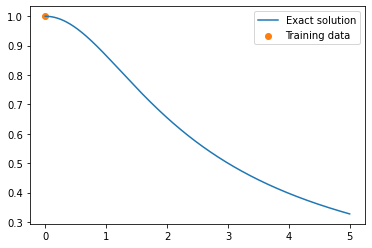

In [5]:
x = torch.linspace(0,5,500)
# Five values of C are learned between 0 and 0.8 ....
d = torch.linspace(0.,0.8,5)

X, D = torch.meshgrid(x, d)
xin = torch.stack((X.flatten(), D.flatten())).T

yin = solutbis(xin).view(-1,1)
print(xin.shape, yin.shape)

# ... slicing the true solution at x=0
x_data=x[0:20:20]
d_data = d

X_data ,D_data = torch.meshgrid(x_data, d_data)
xin_data = torch.stack((X_data.flatten(), D_data.flatten())).T
yin_data = solutbis(xin_data).view(-1,1)
yin_data[0]=1.
yin_data[1]=1.
yin_data[2]=1.
yin_data[3]=1.
yin_data[4]=1.
#for Five values of C ......

print(xin_data.shape, yin_data.shape)

plt.figure()
d_value = 0.2
xin_slice = xin[:, 1] == d_value
plt.plot(xin[xin_slice, 0], yin[xin_slice, 0], label="Exact solution")
xin_data_slice = xin_data[:, 1] == d_value
plt.scatter(xin_data[xin_data_slice, 0], yin_data[xin_data_slice, 0], color="tab:orange", label="Training data")
plt.legend()
plt.show()





## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

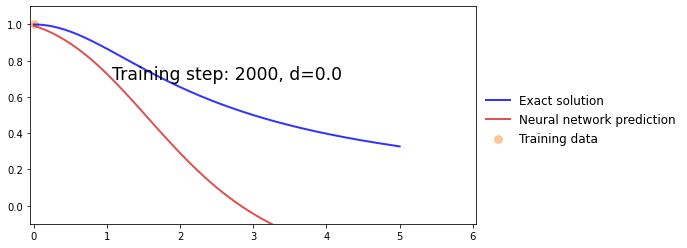

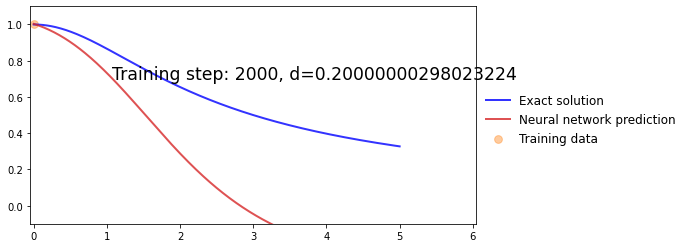

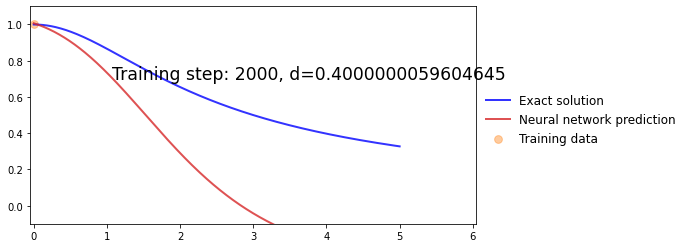

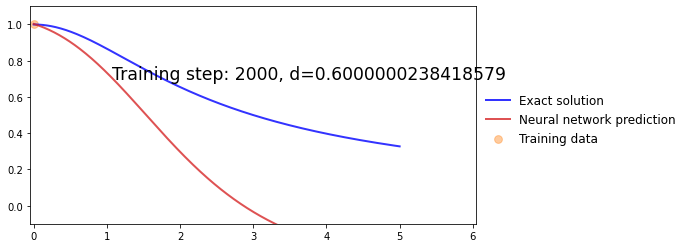

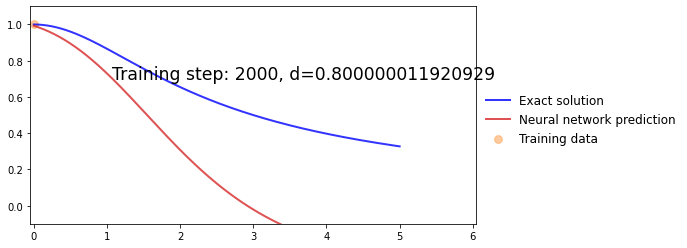

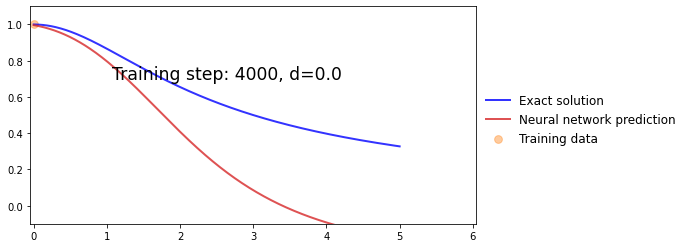

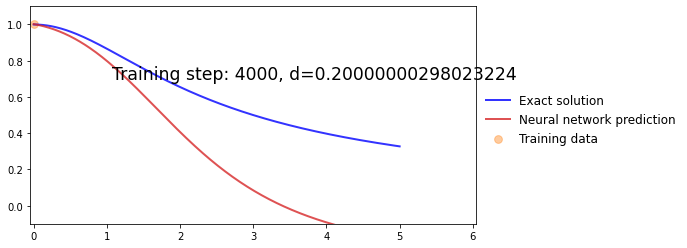

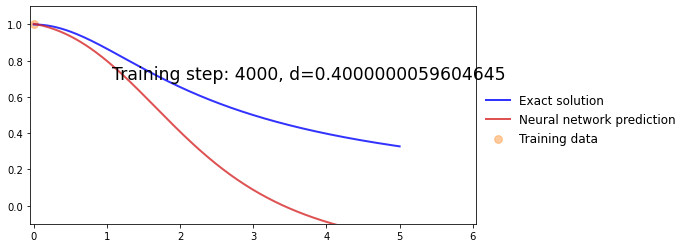

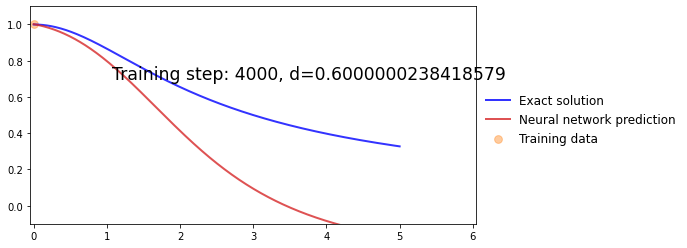

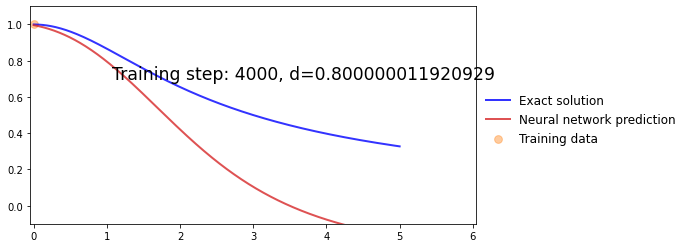

In [6]:
def plot_result(xin, yin, xin_data, yin_data, yh, d_value, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))

    xin_slice = xin[:, 1] == d_value
    plt.plot(xin[xin_slice, 0], yin[xin_slice, 0], color="blue", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(xin[xin_slice, 0], yh[xin_slice, 0], color="tab:red", linewidth=2, alpha=0.8, label="Neural network prediction")

    xin_data_slice = xin_data[:, 1] == d_value
    plt.scatter(xin_data[xin_data_slice, 0], yin_data[xin_data_slice, 0], s=60, color="tab:orange",
                alpha=0.4, label='Training data')

    if xp is not None:
        xp_slice = xp[:, 1] == d_value
        plt.scatter(xp[xp_slice, 0], -0*torch.ones_like(xp[xp_slice,0]), s=30, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 6.05)
    plt.ylim(-0.1, 1.1)
    plt.text(1.065,0.7,f"Training step: {i+1}, d={d_value}",fontsize="xx-large",color="k")
    plt.axis("on")

# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(2, 1, 20, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(4000):
    optimizer.zero_grad()
    yh = model(xin_data)
    loss = torch.mean((yh - yin_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if (i+1) % 10 == 0: 
        yh = model(xin).detach()

        for d_value in d:
            plot_result(xin, yin, xin_data, yin_data, yh, d_value)

        file = "plots/nn_%.8i.png"%(i+1)
        #plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 2000 == 0: plt.show()
        else: plt.close("all")

#save_gif_PIL("nn.gif", files, fps=20, loop=0)







## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at ...

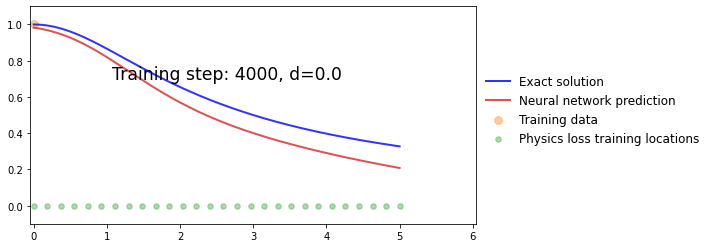

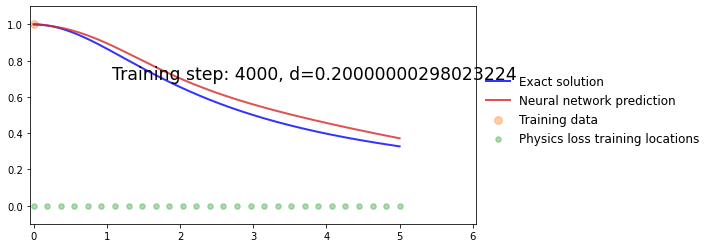

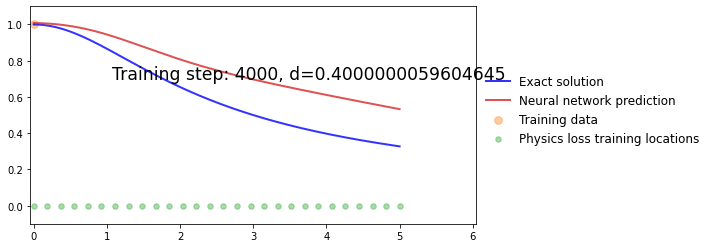

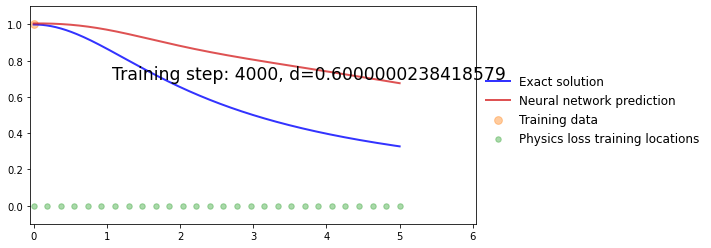

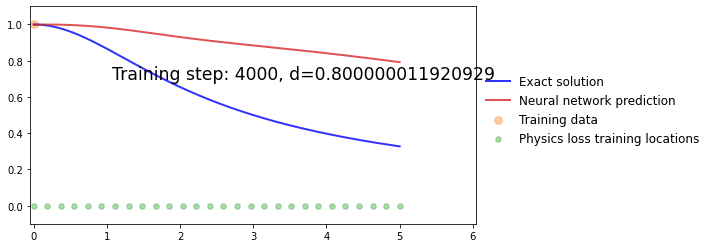

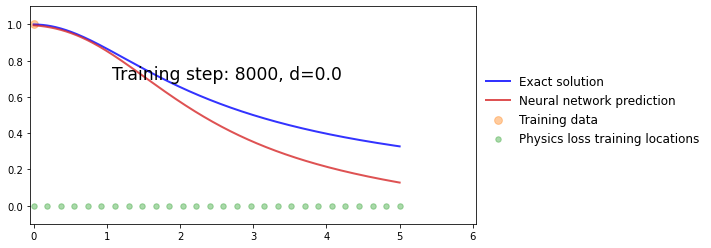

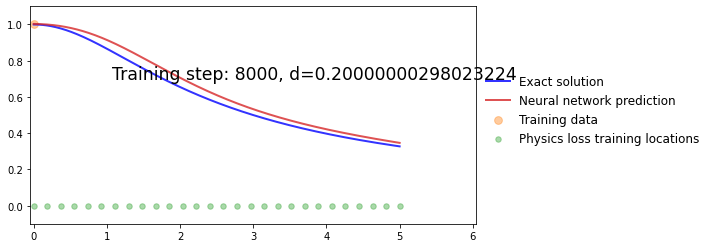

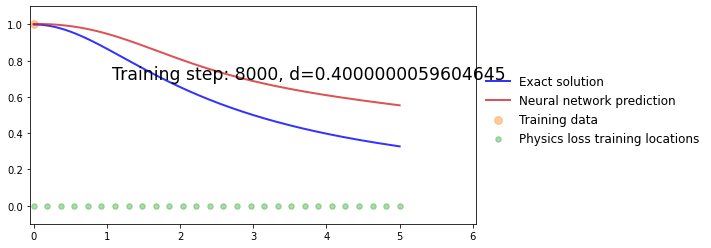

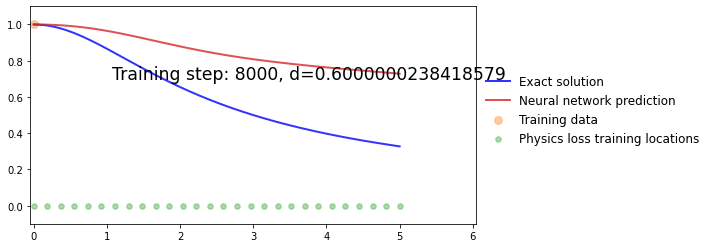

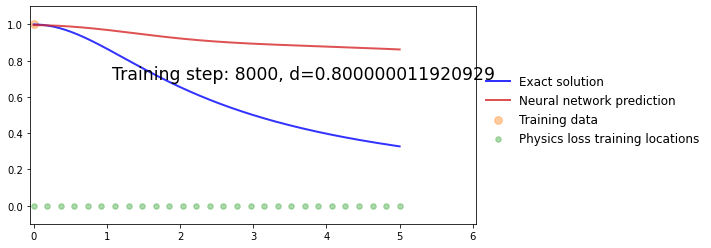

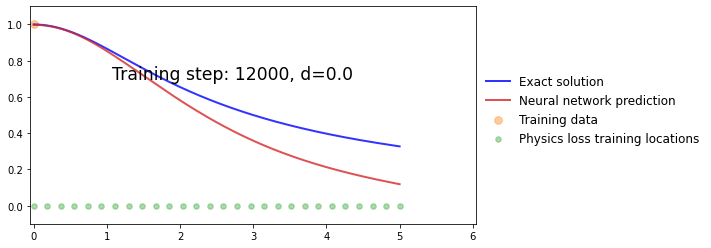

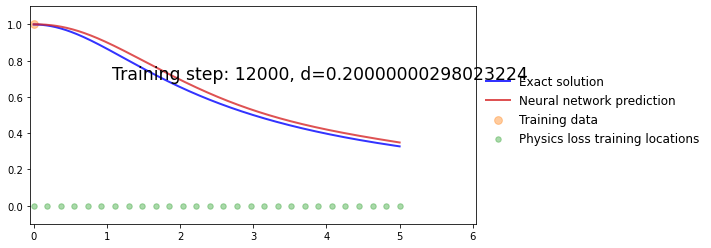

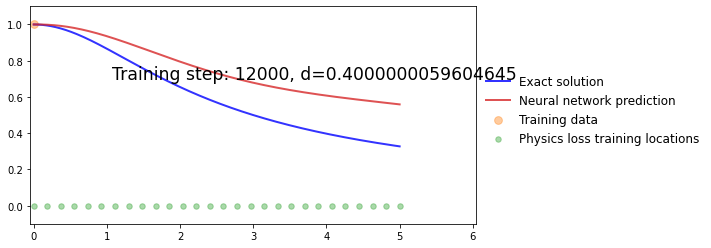

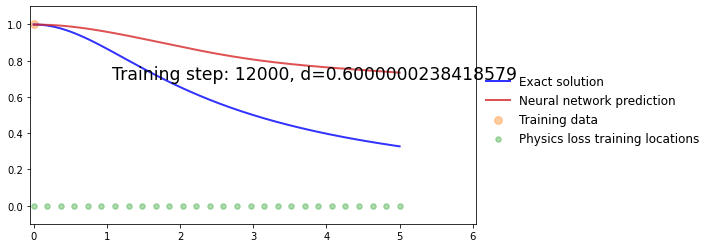

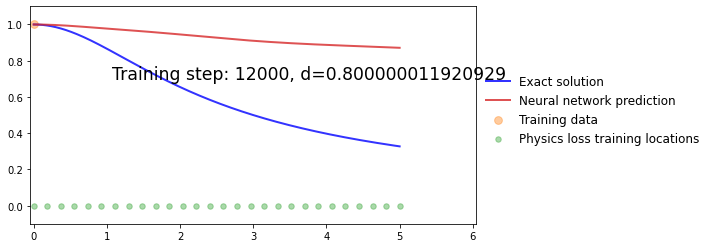

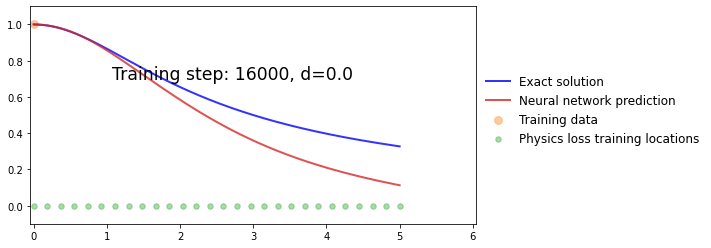

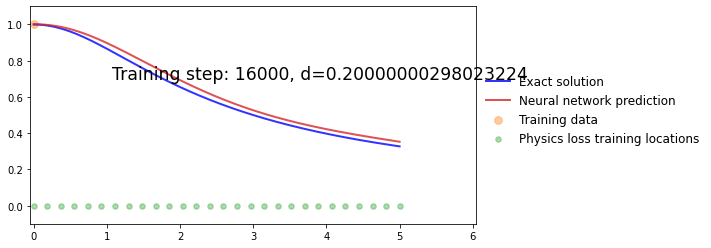

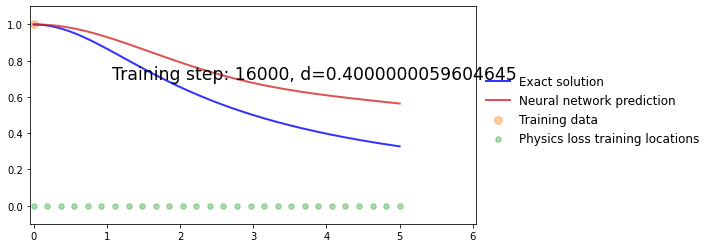

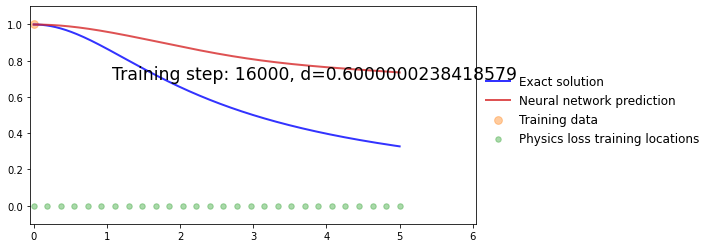

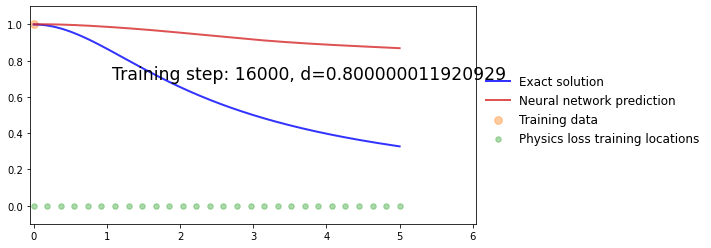

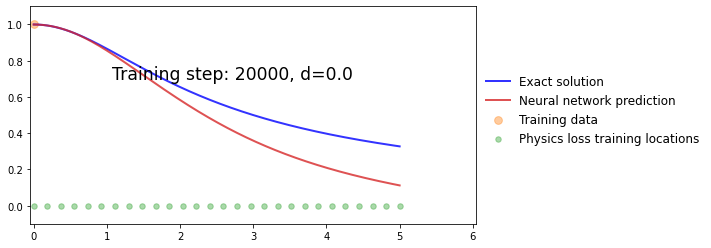

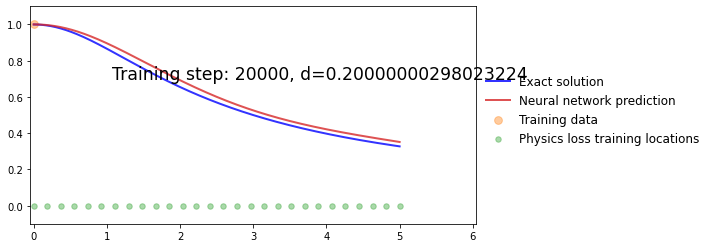

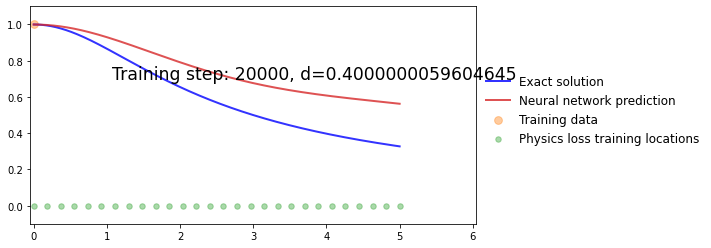

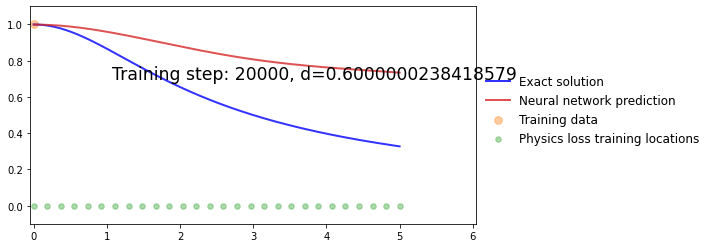

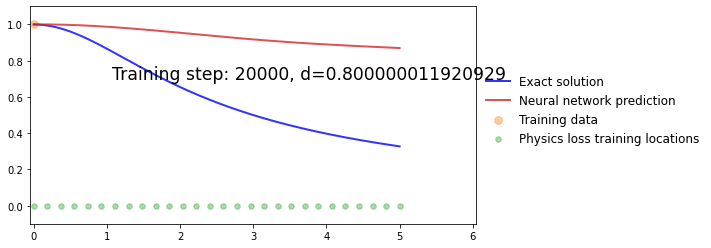

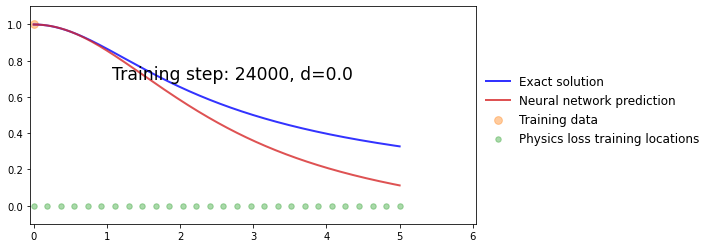

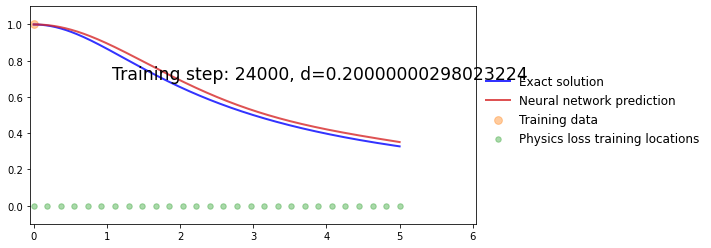

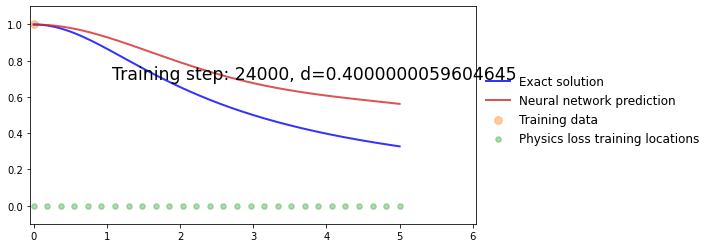

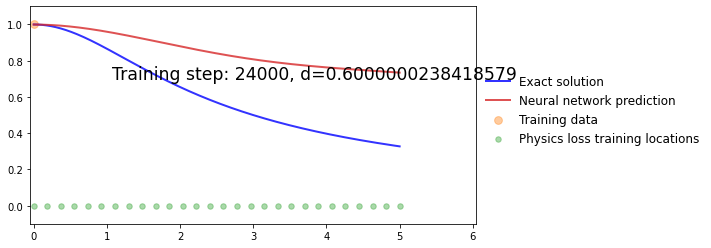

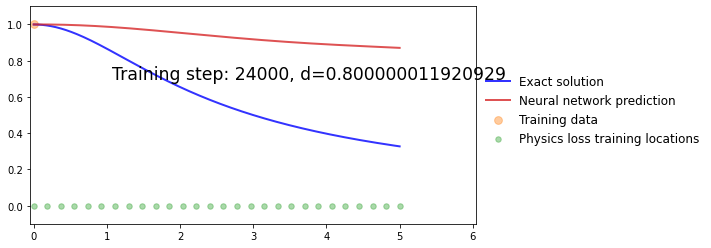

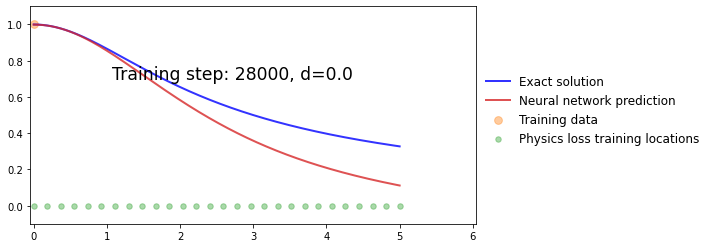

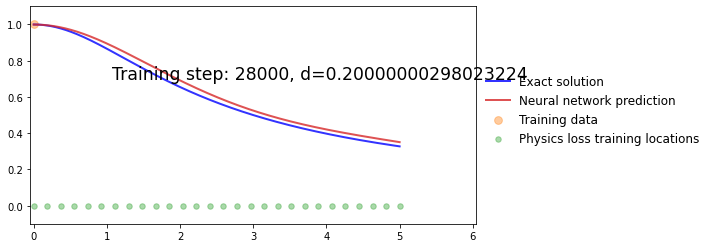

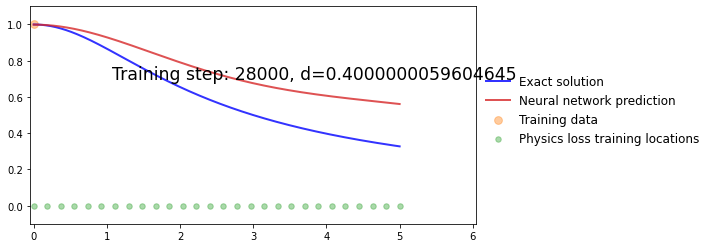

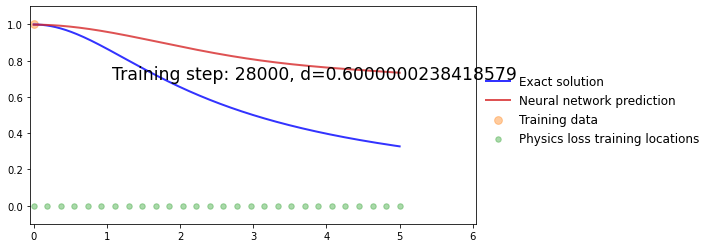

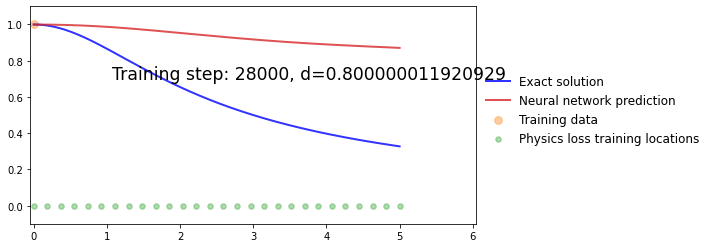

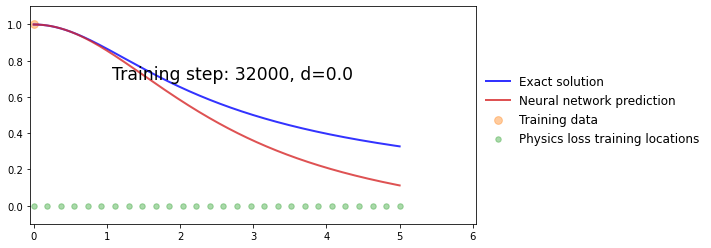

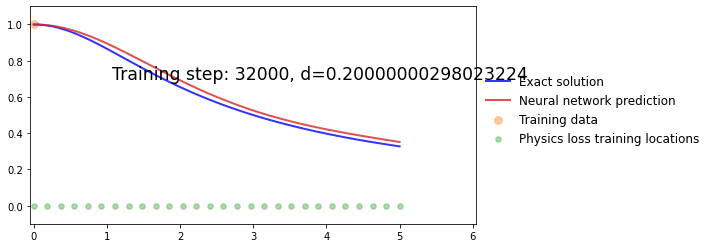

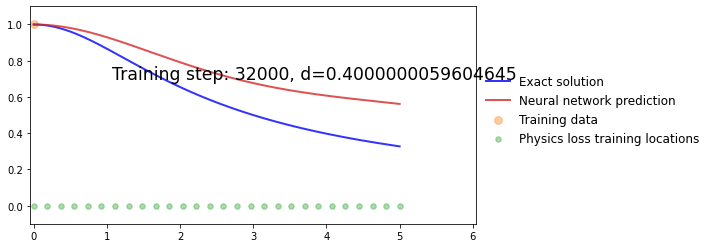

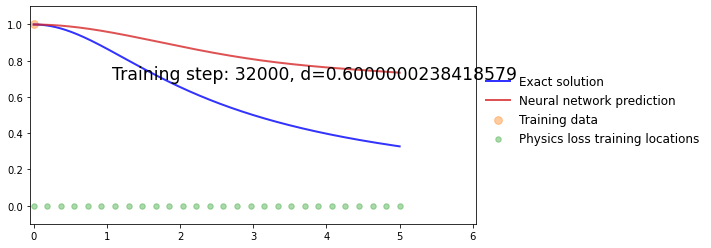

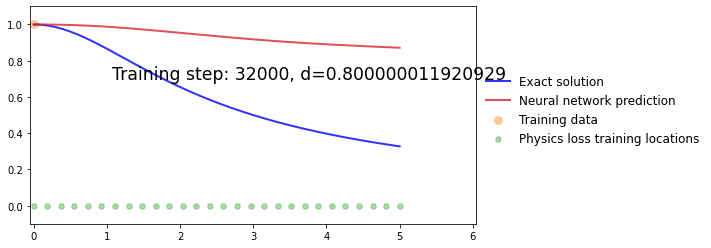

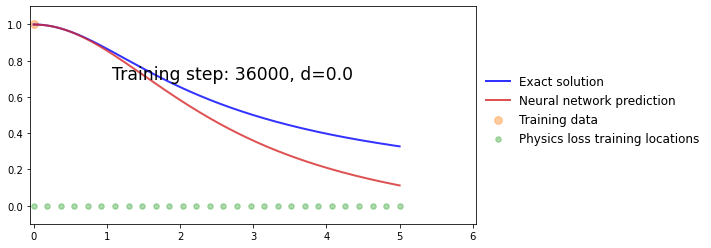

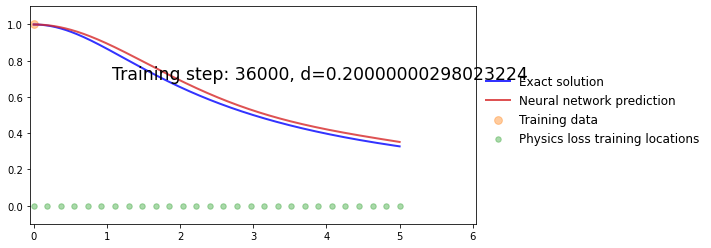

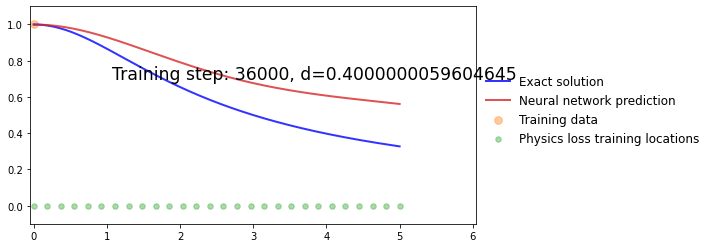

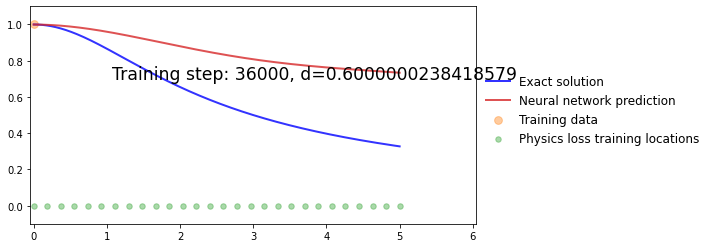

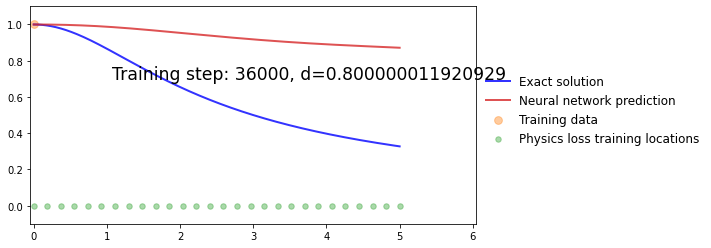

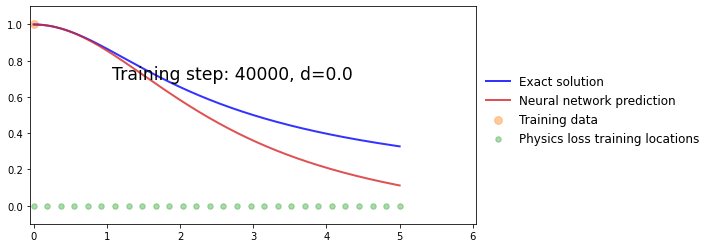

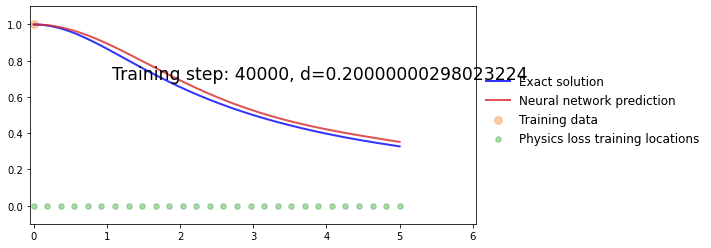

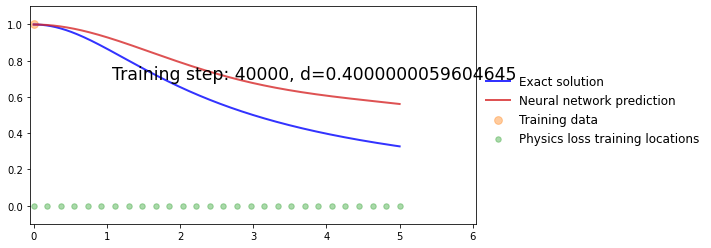

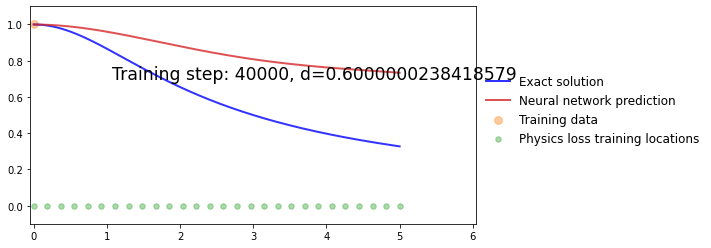

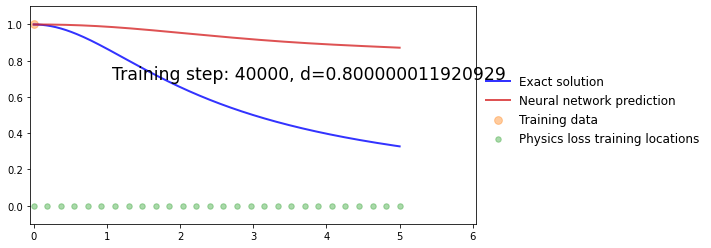

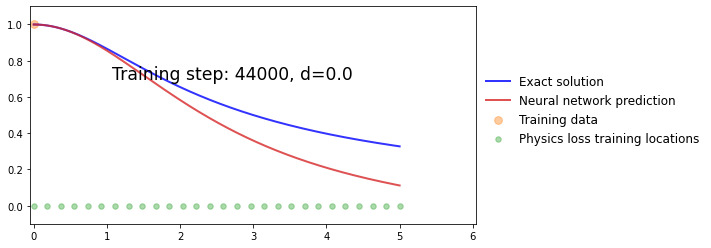

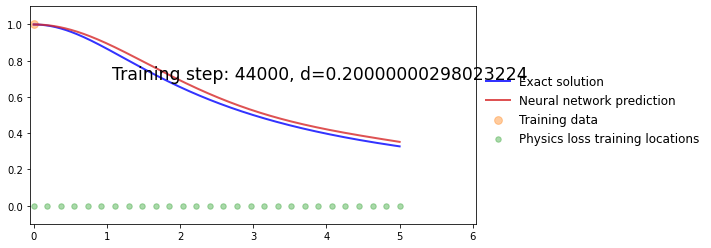

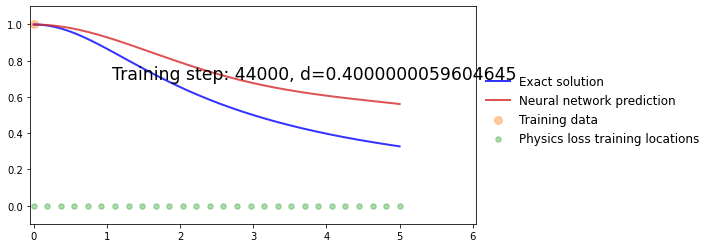

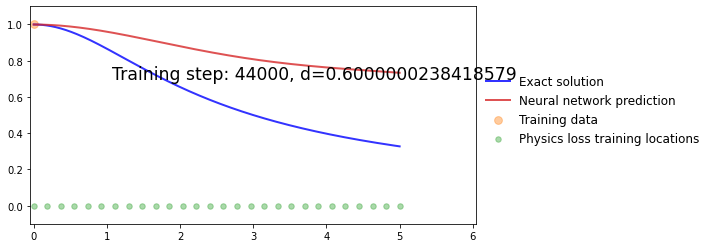

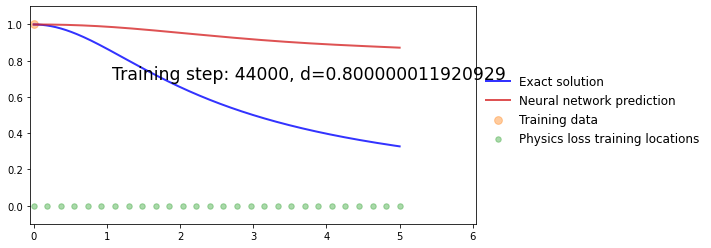

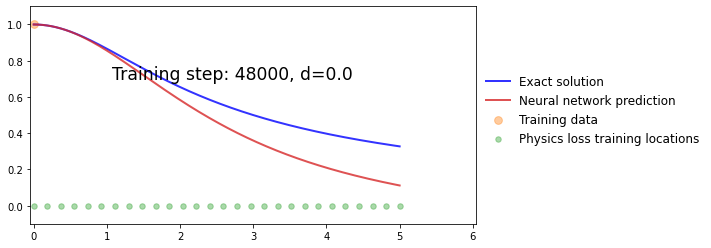

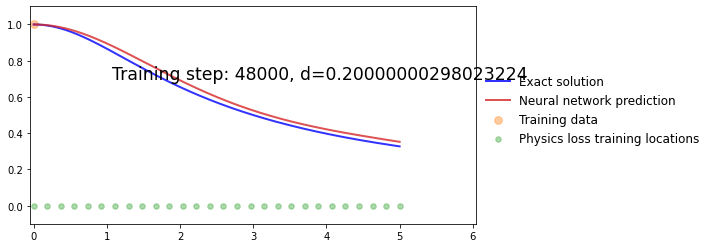

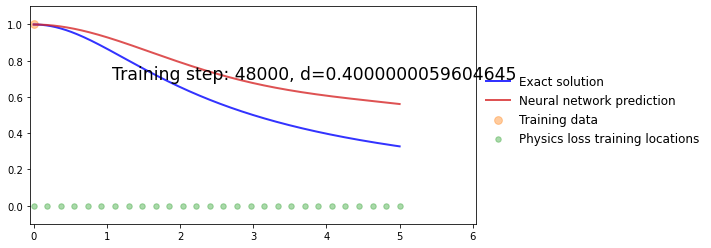

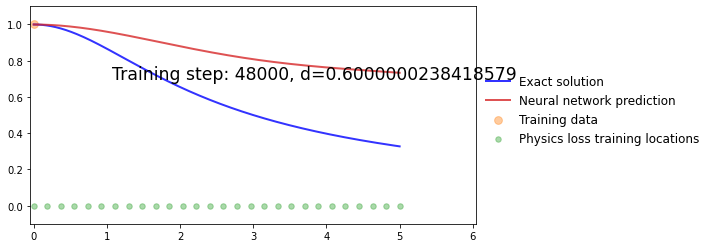

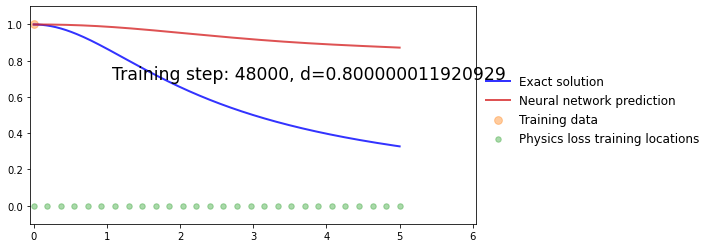

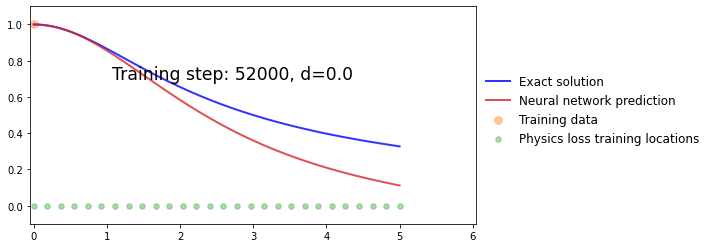

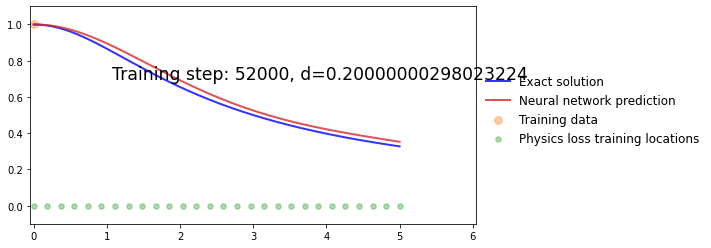

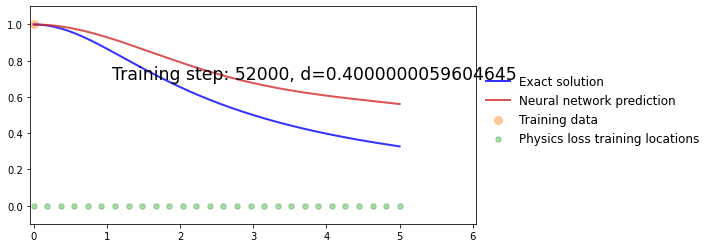

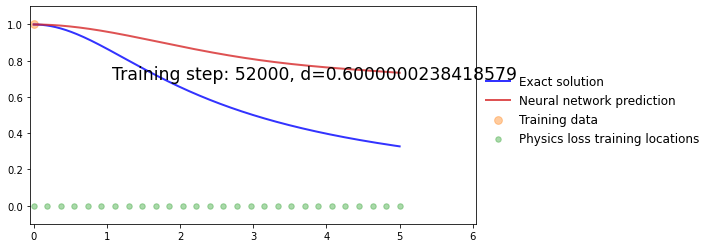

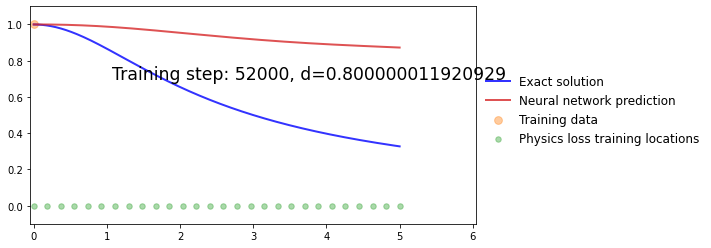

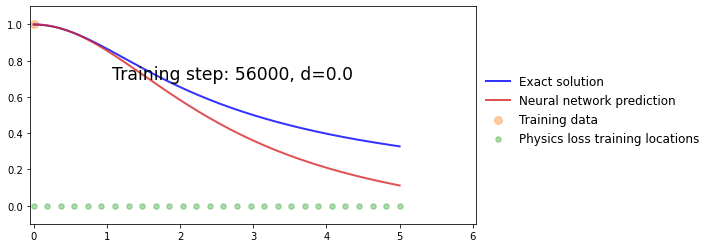

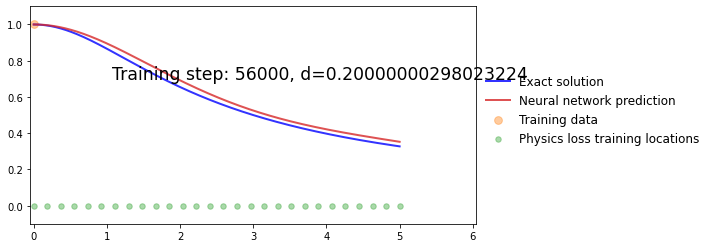

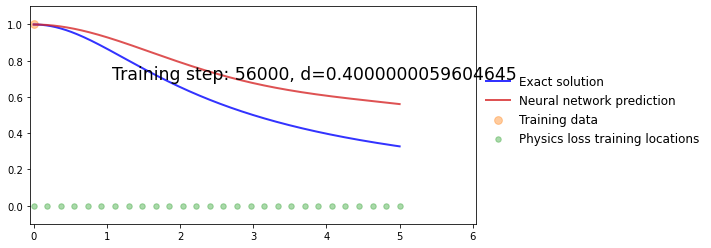

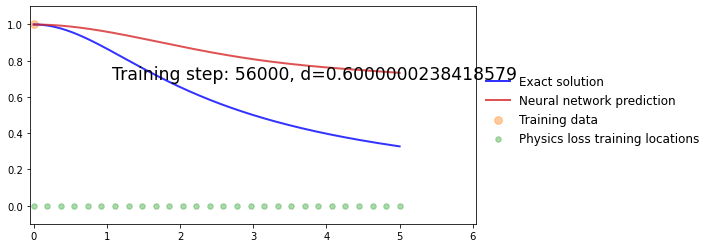

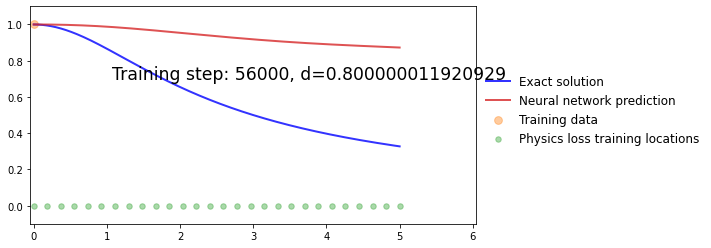

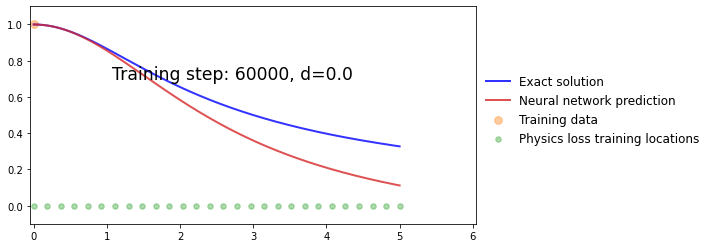

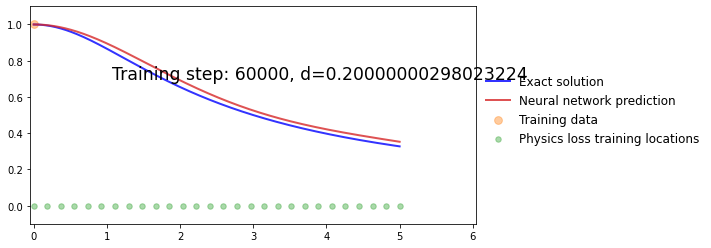

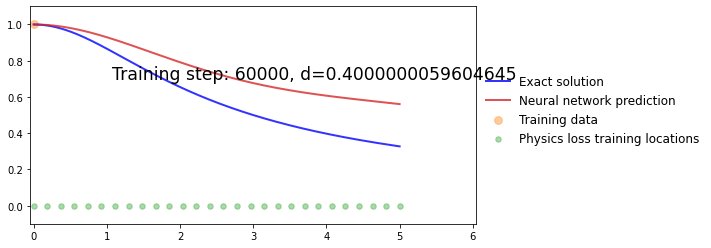

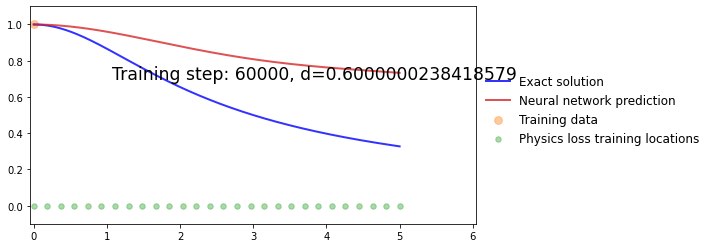

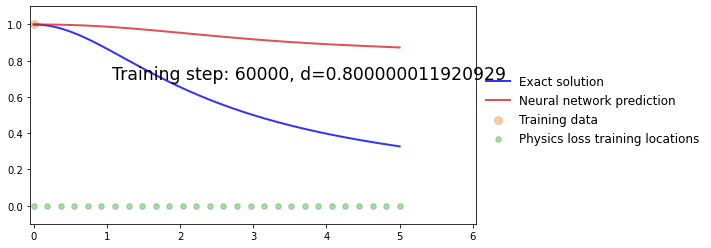

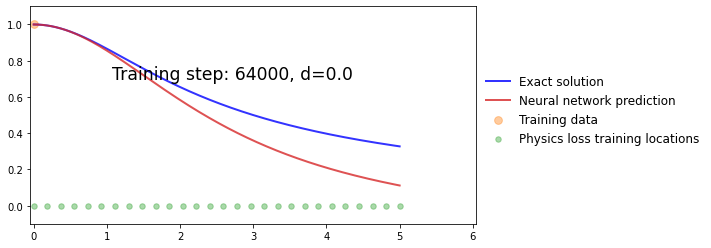

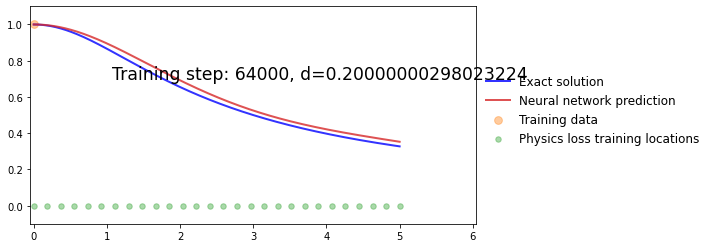

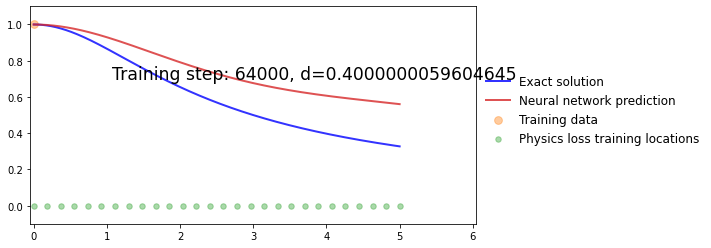

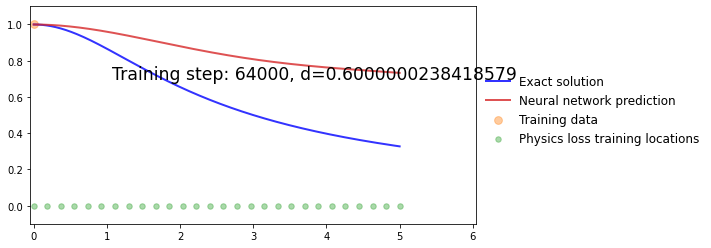

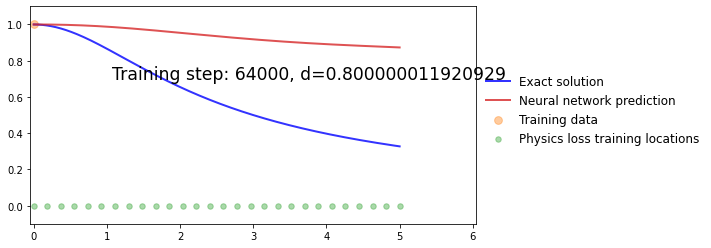

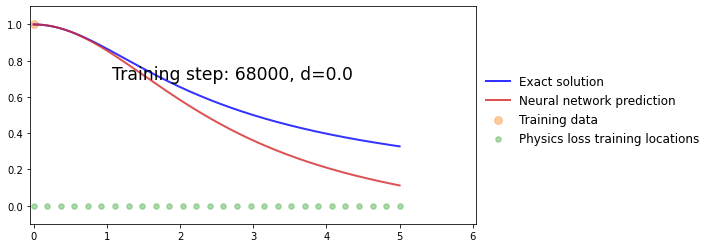

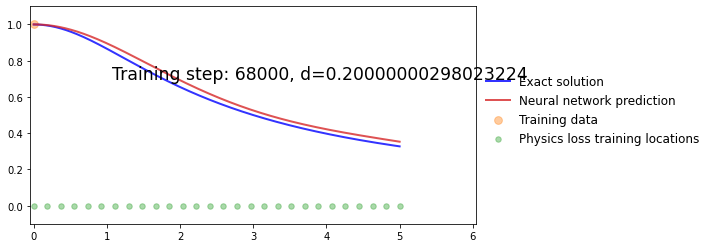

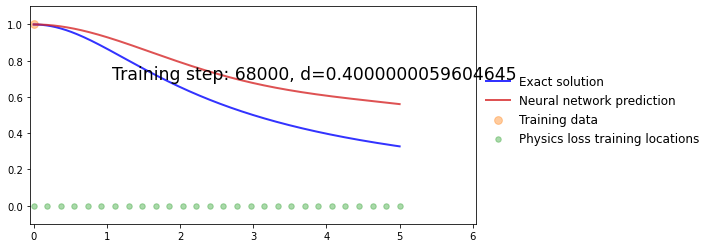

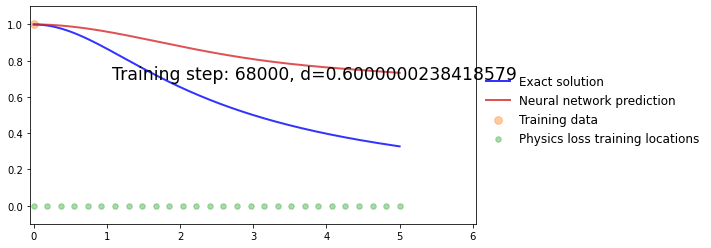

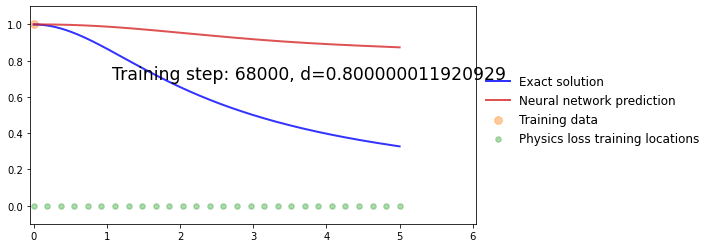

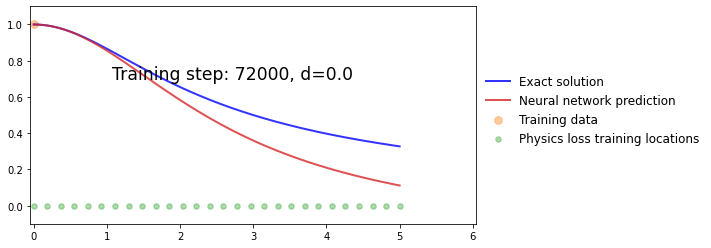

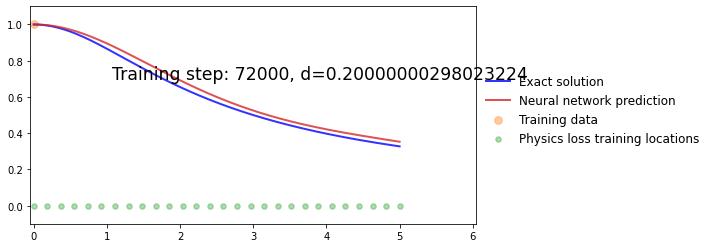

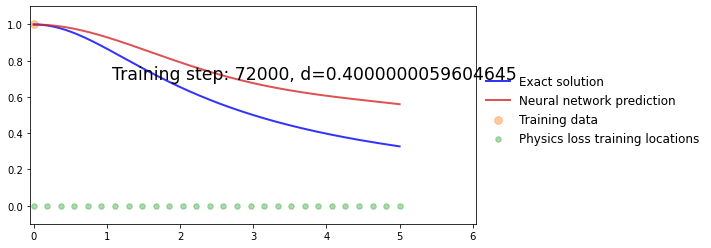

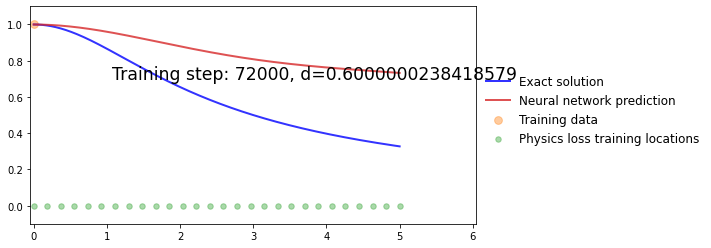

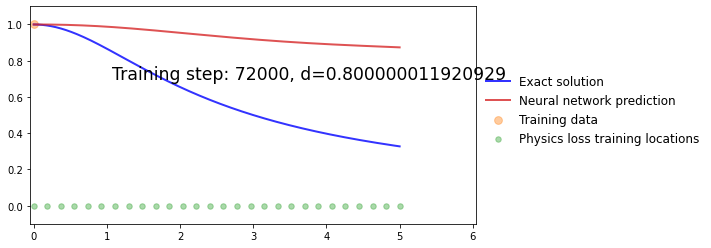

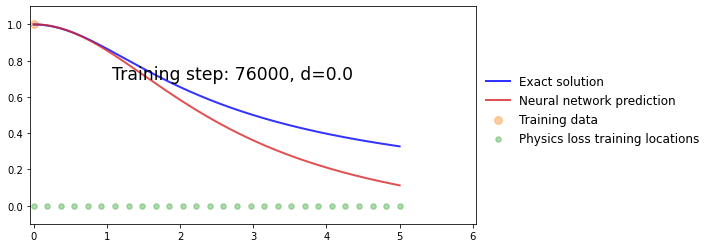

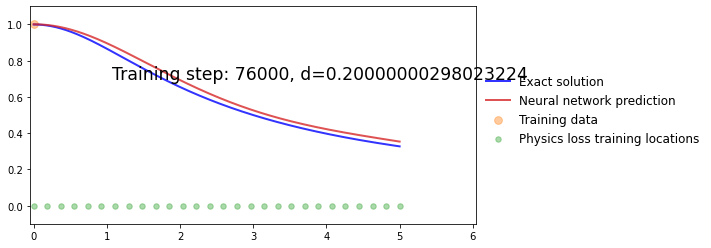

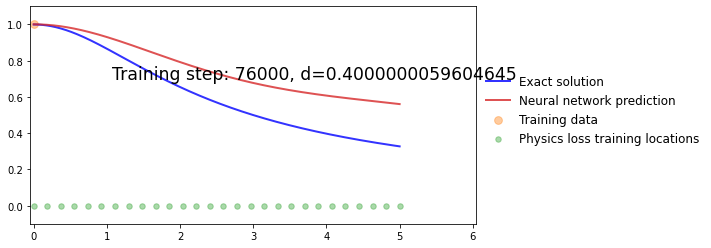

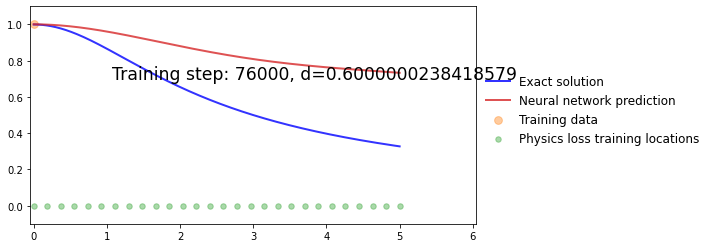

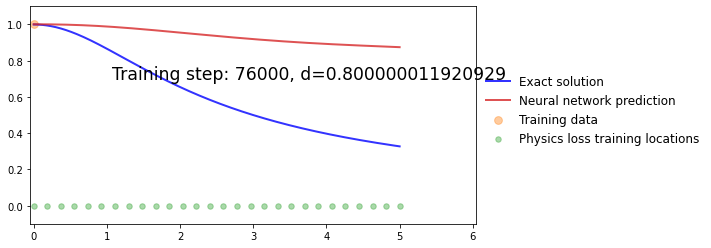

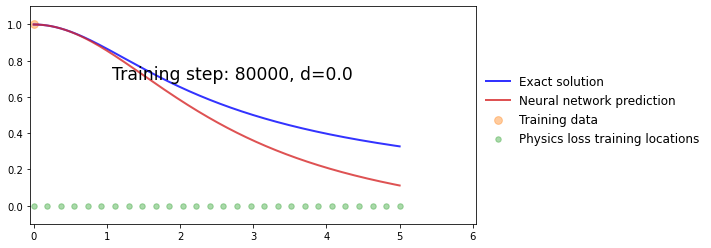

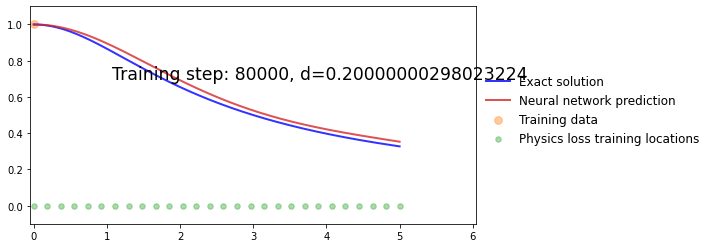

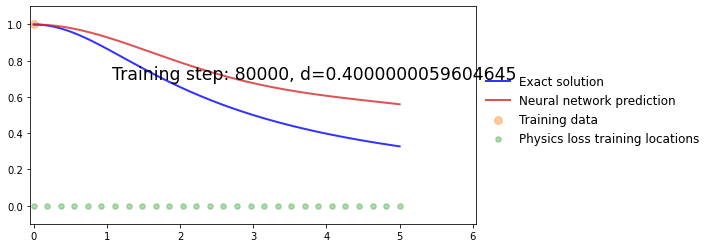

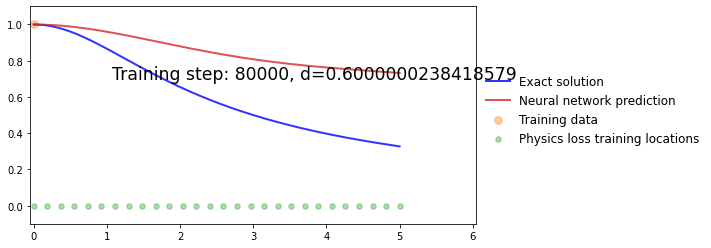

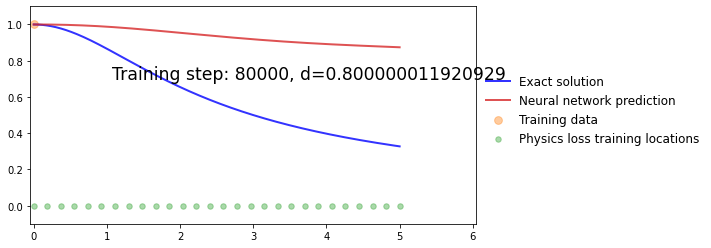

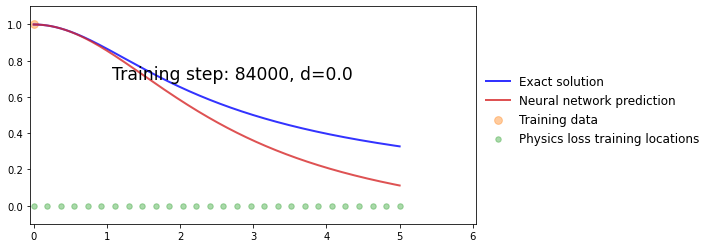

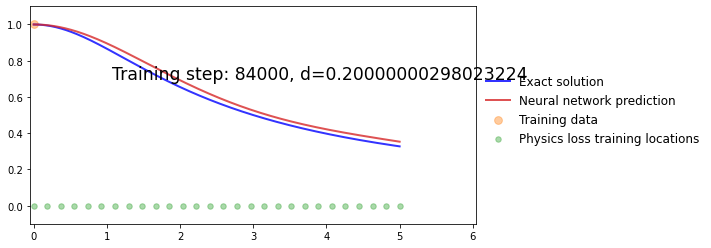

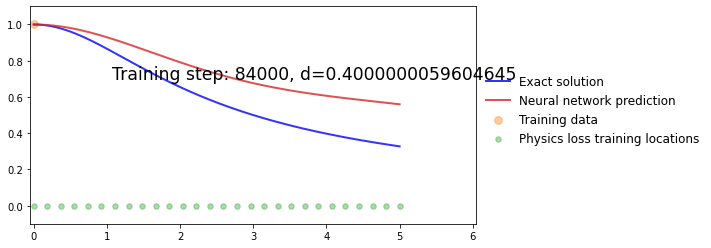

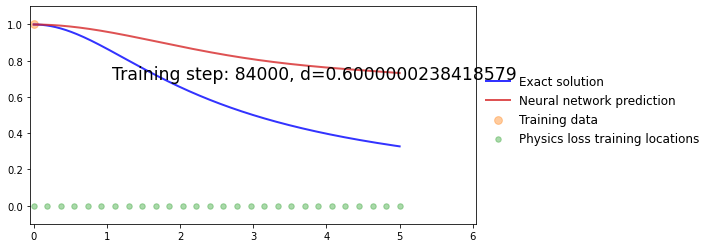

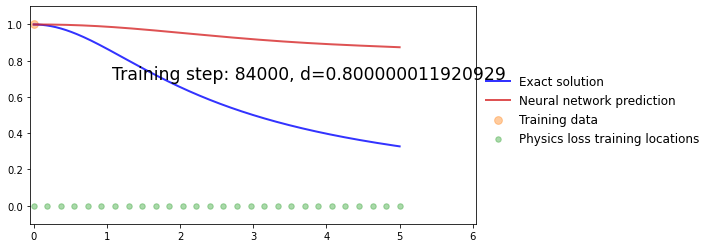

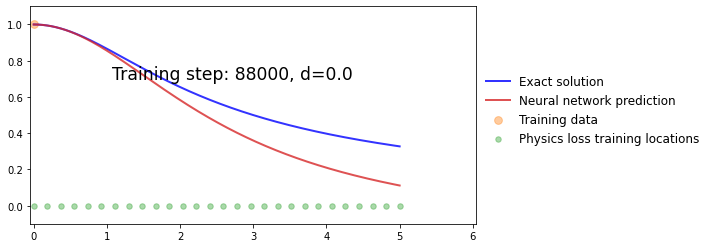

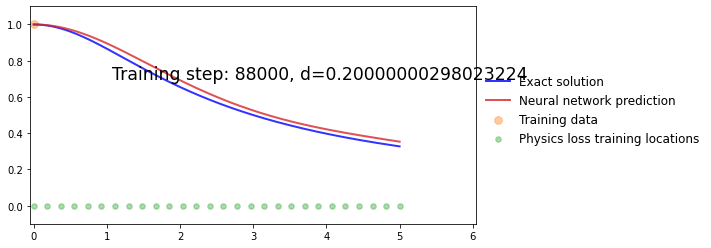

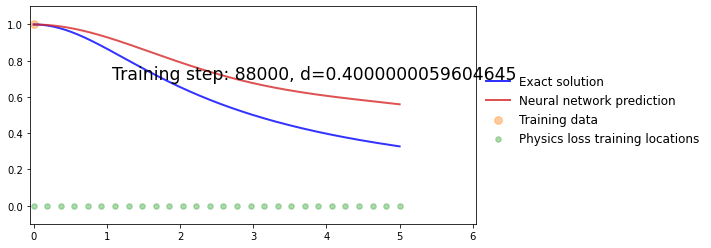

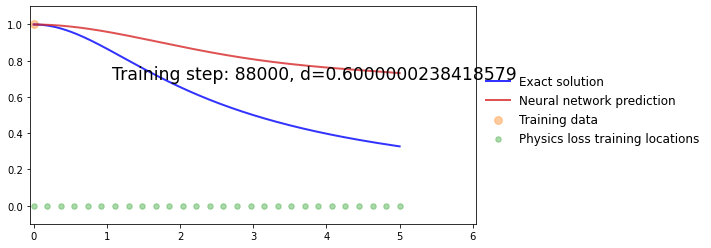

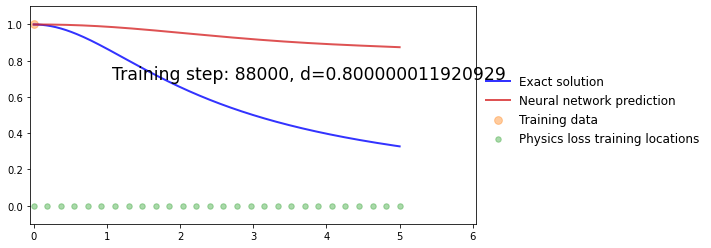

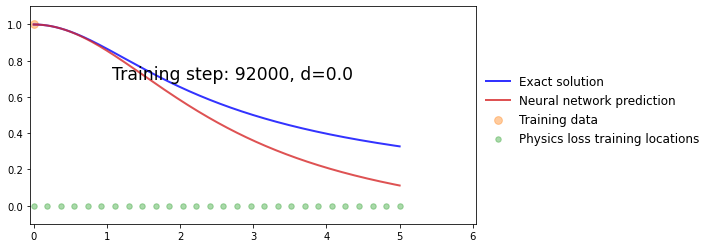

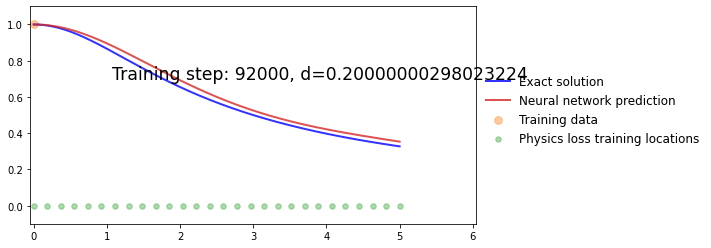

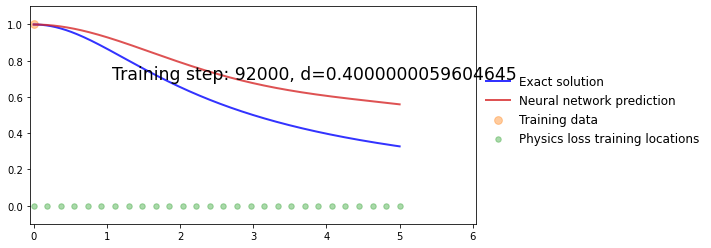

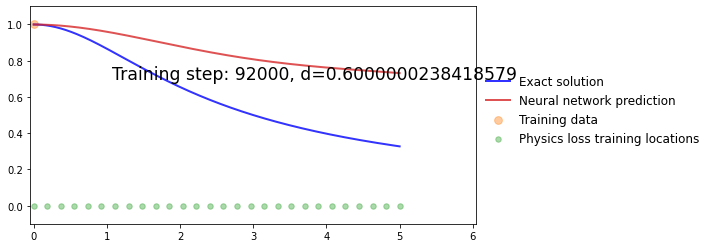

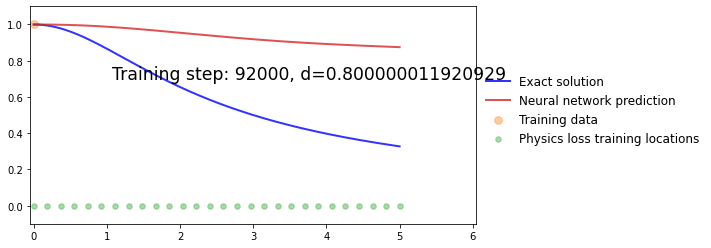

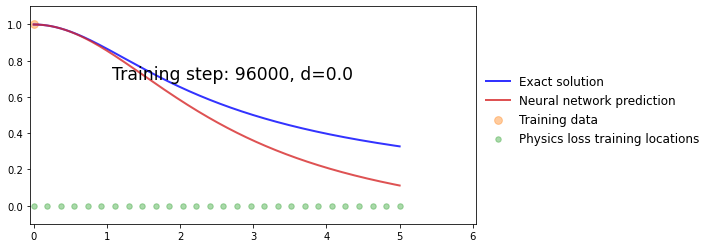

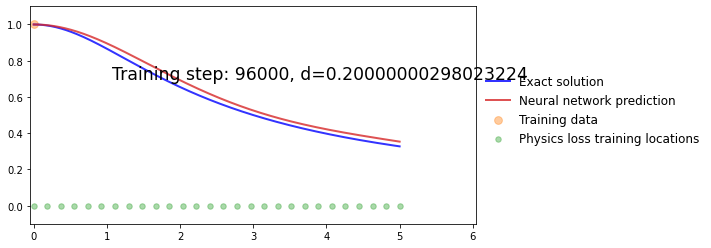

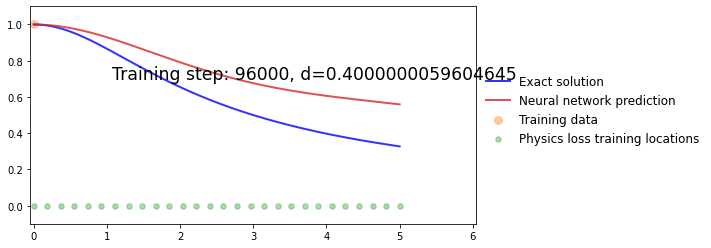

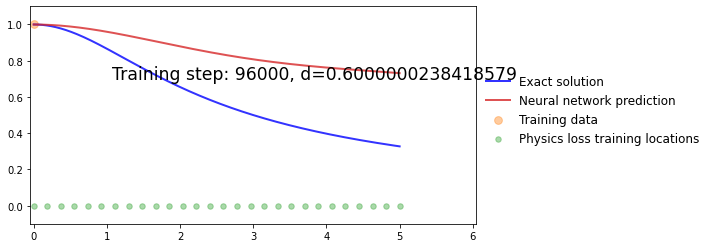

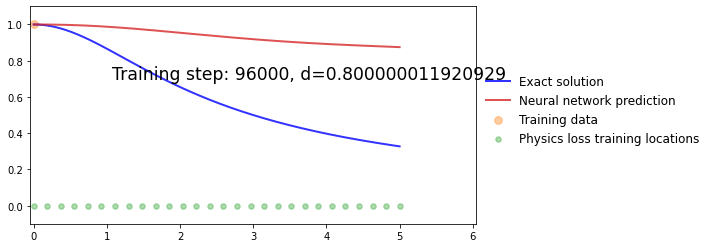

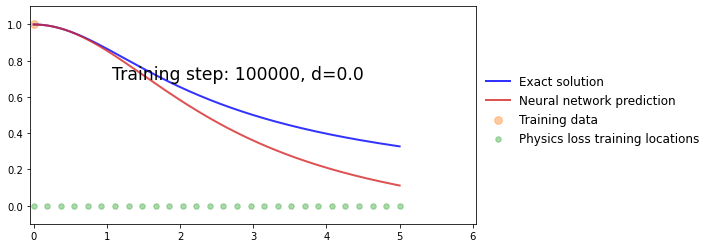

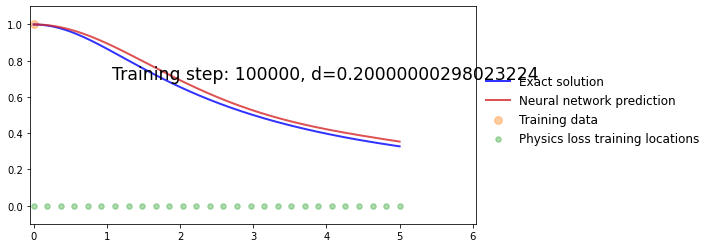

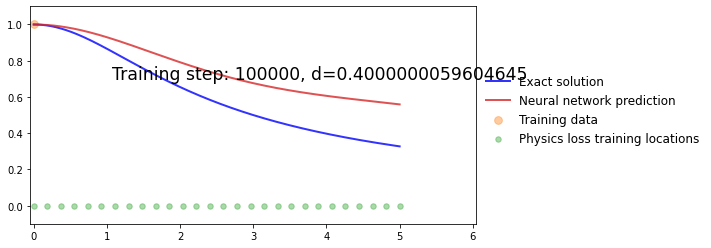

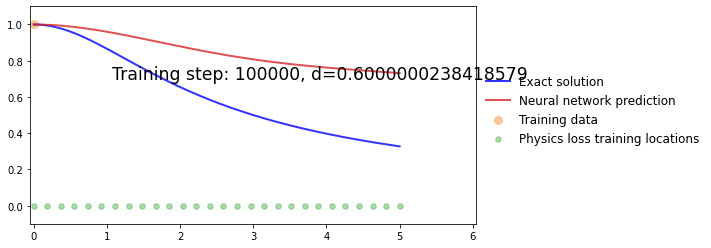

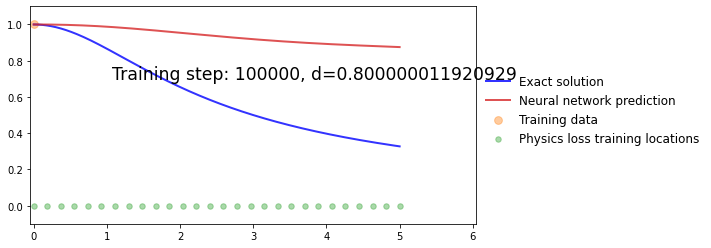

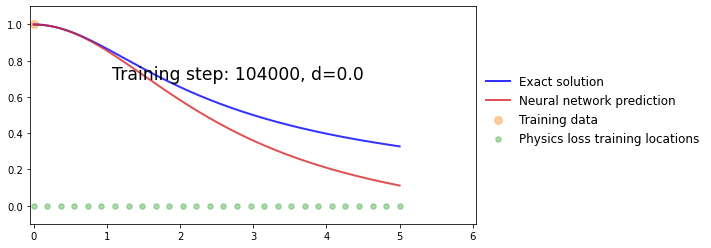

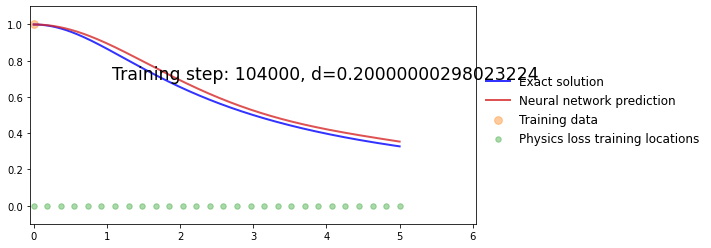

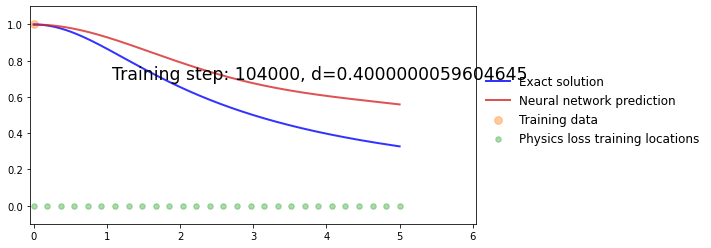

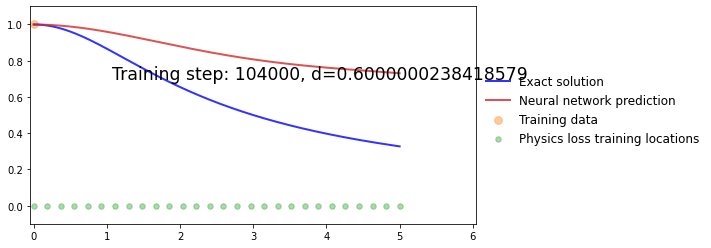

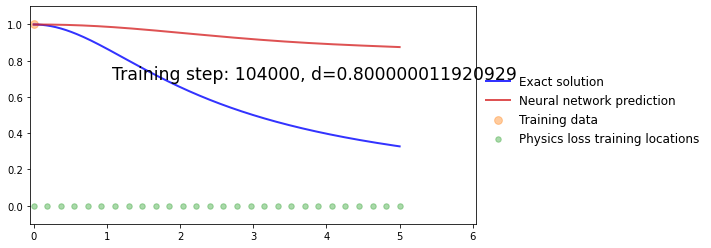

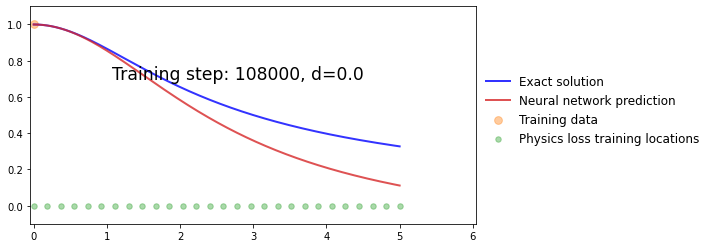

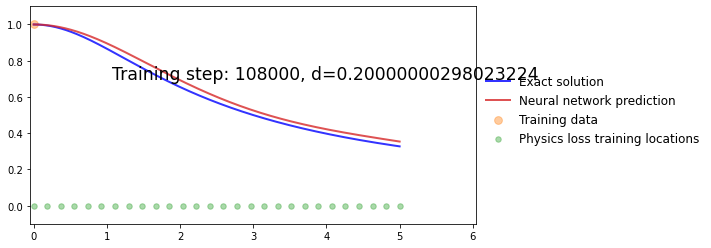

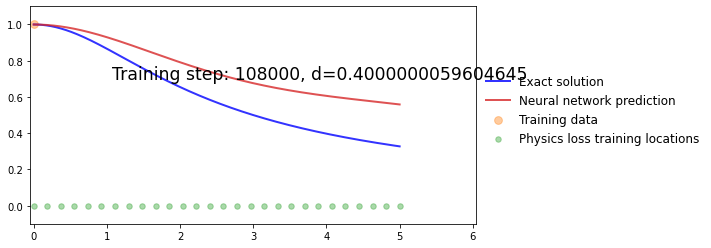

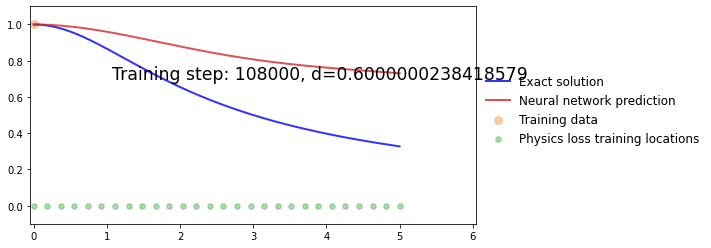

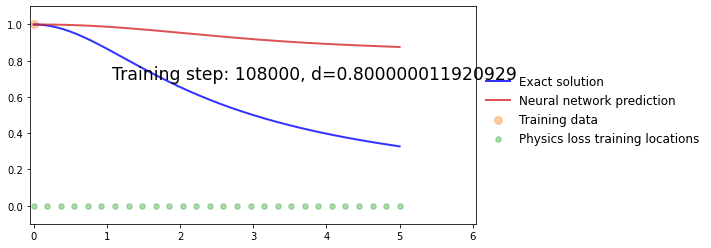

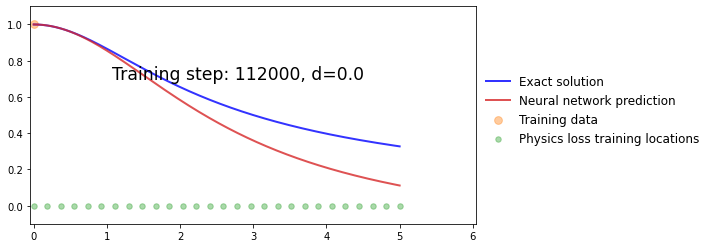

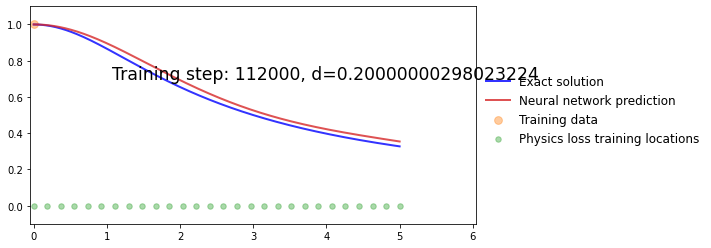

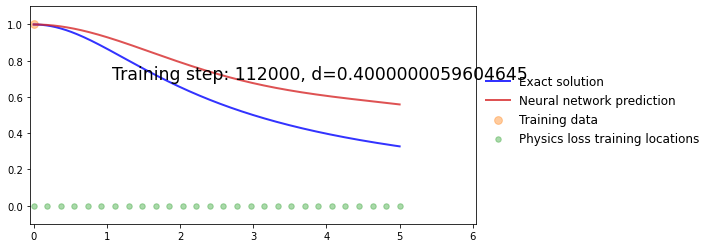

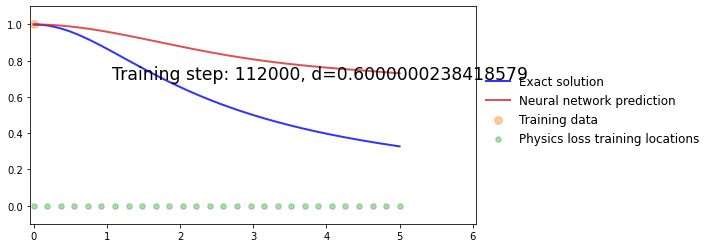

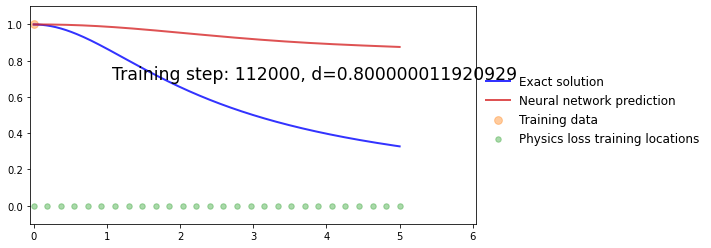

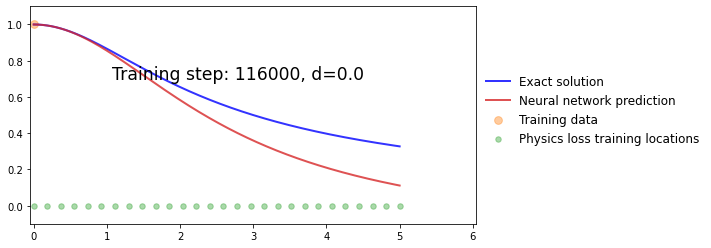

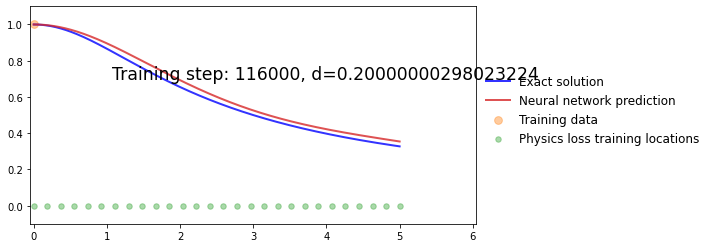

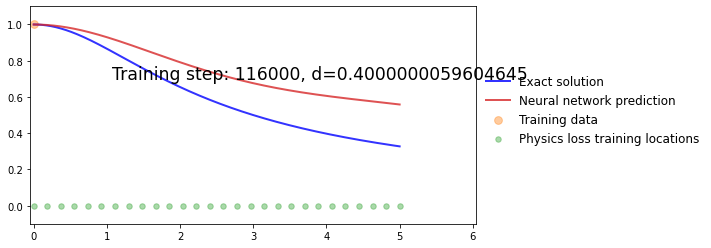

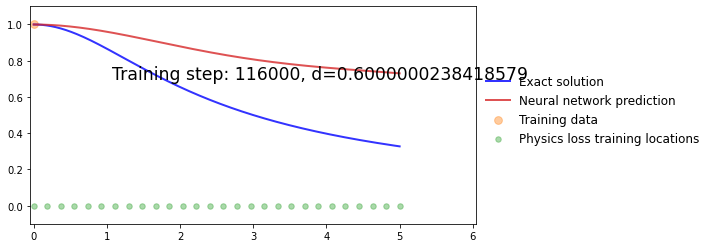

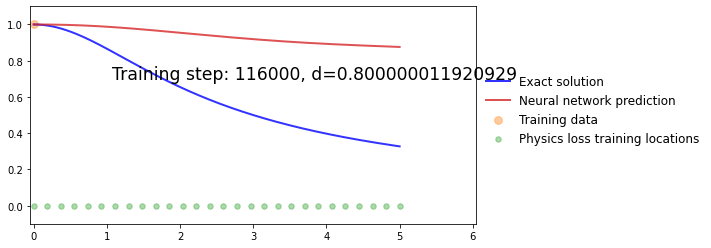

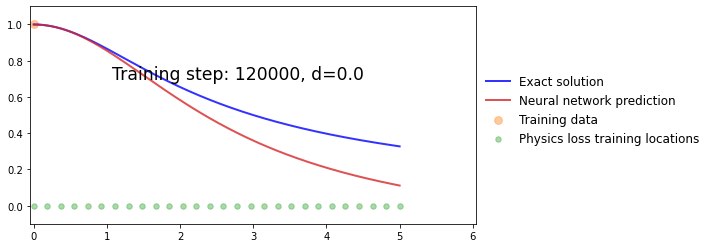

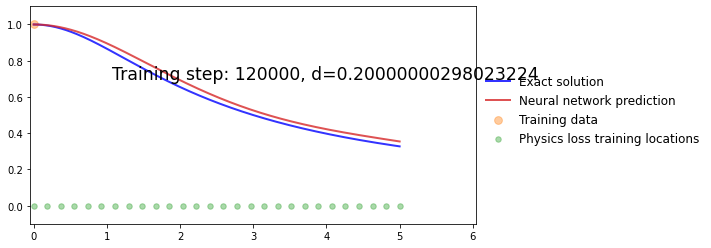

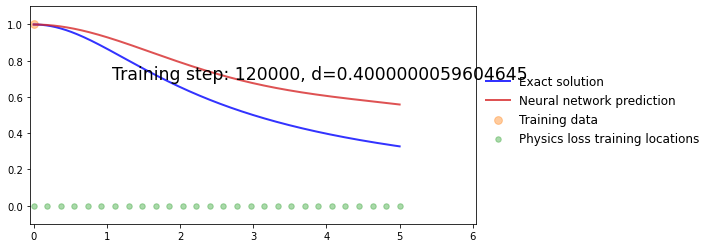

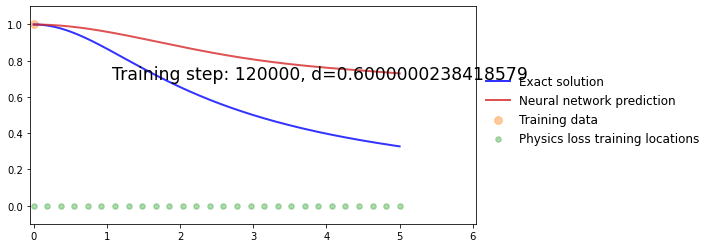

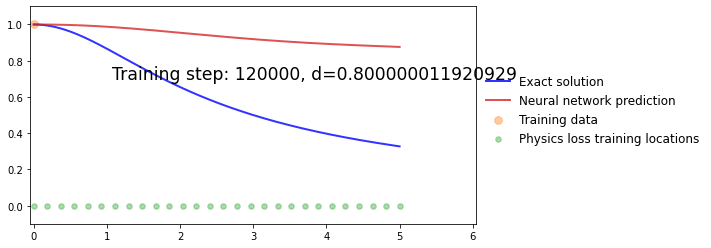

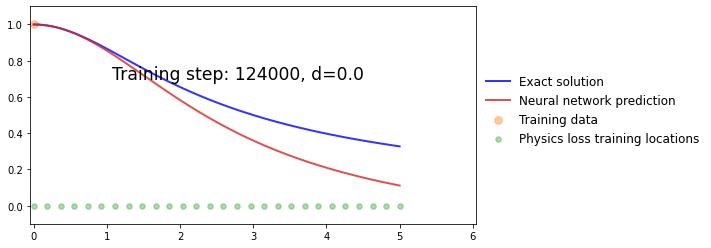

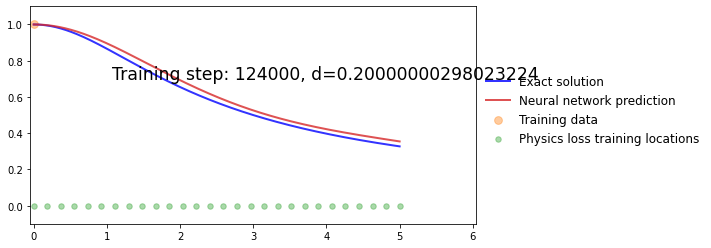

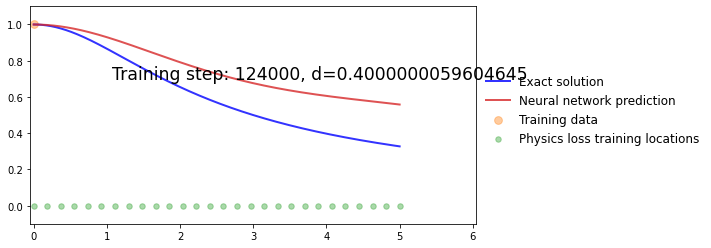

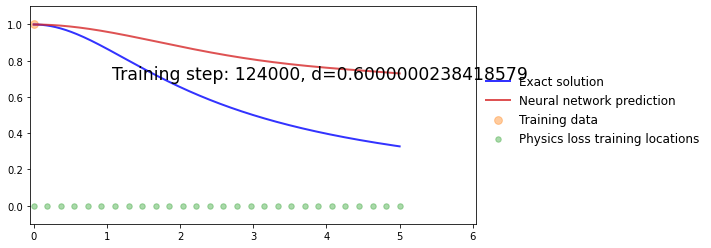

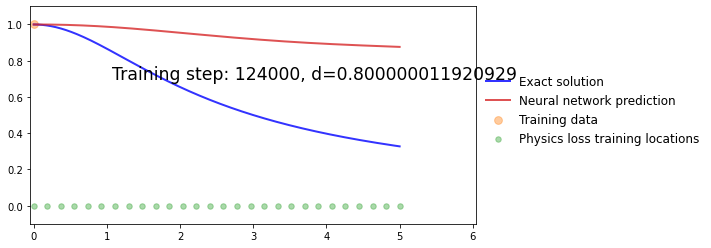

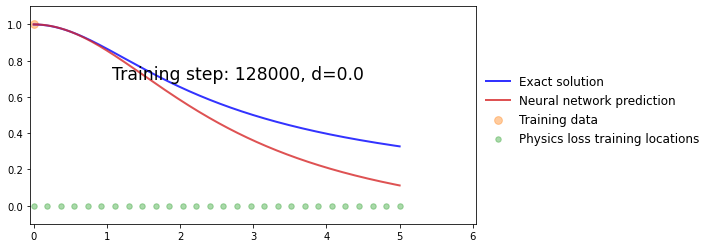

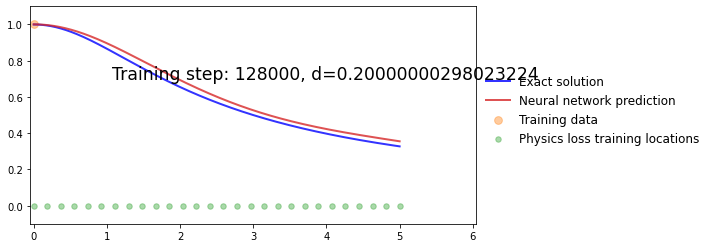

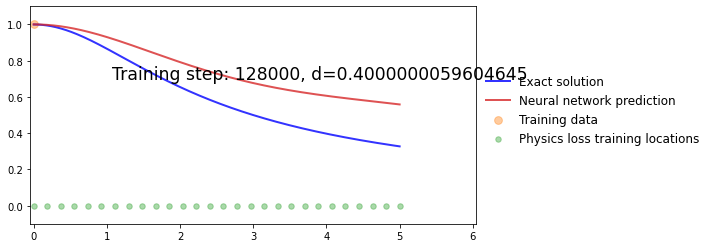

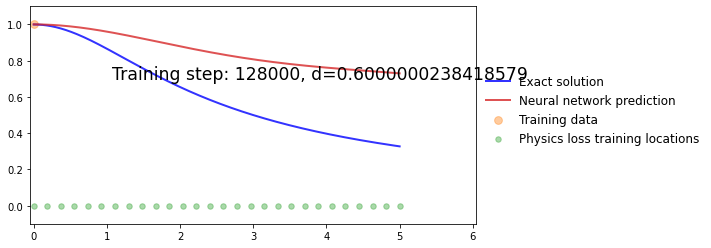

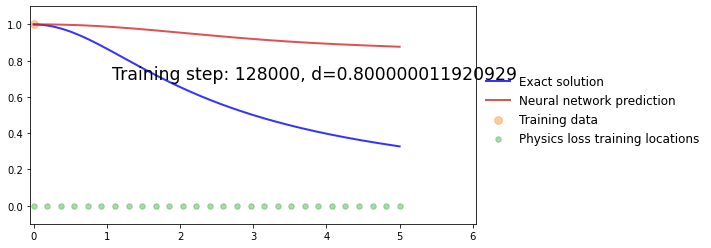

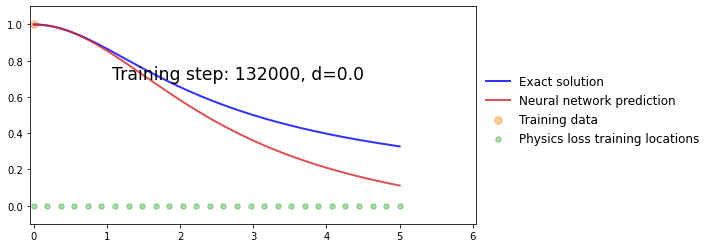

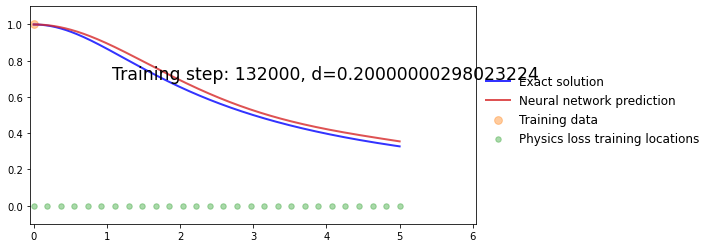

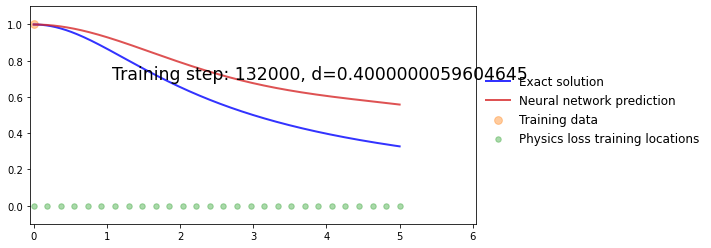

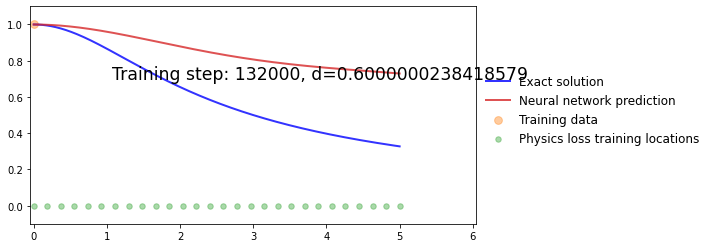

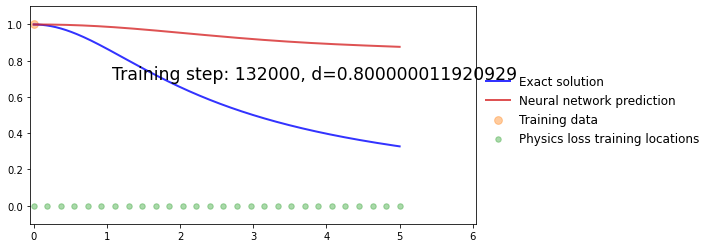

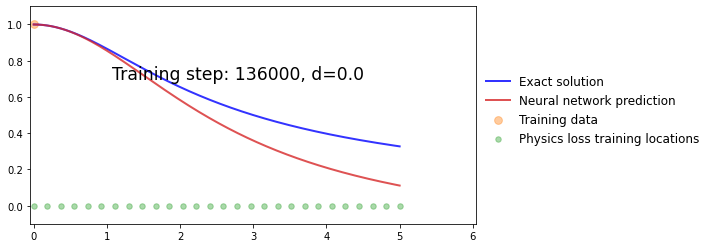

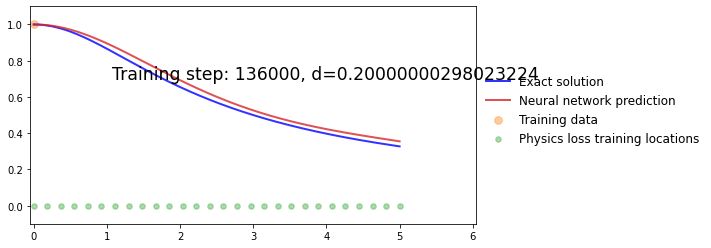

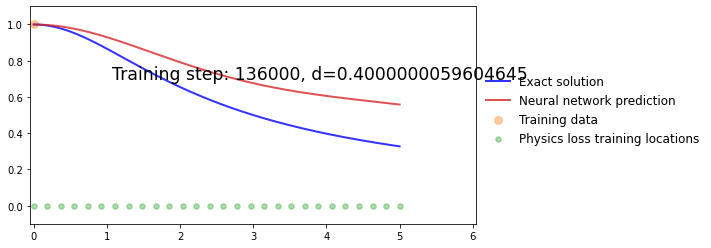

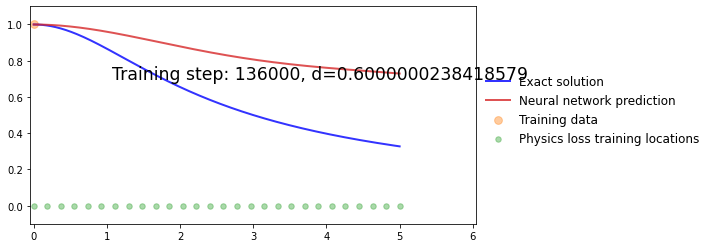

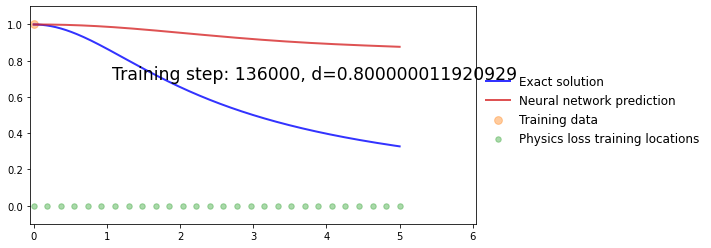

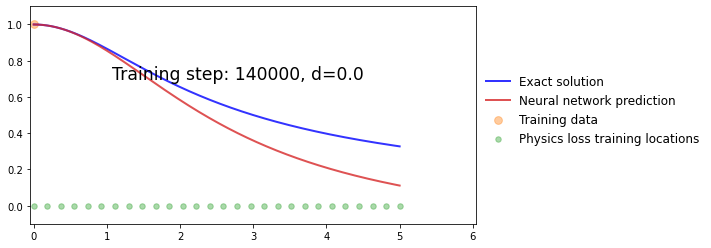

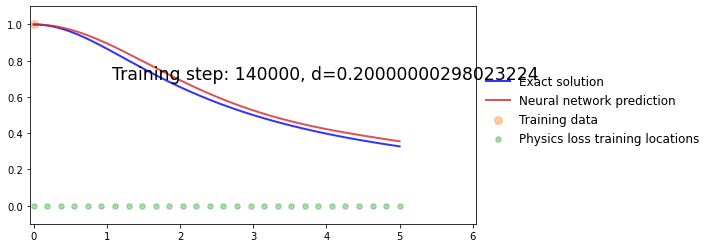

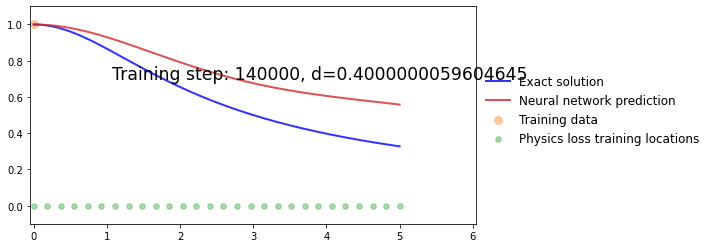

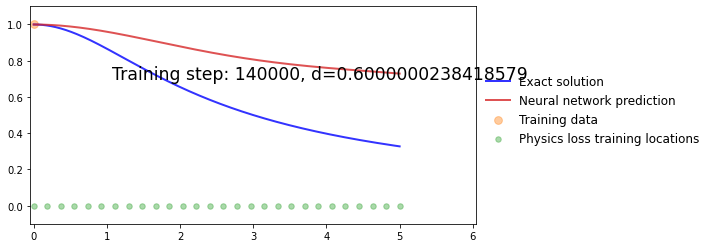

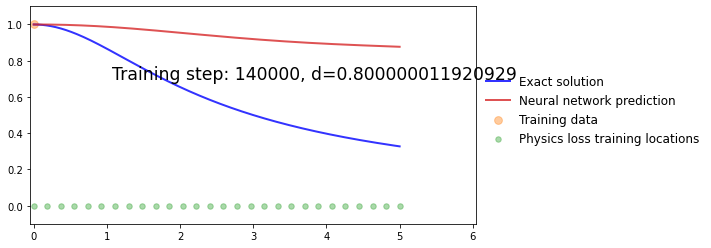

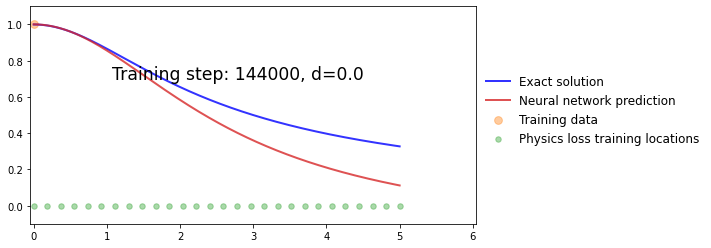

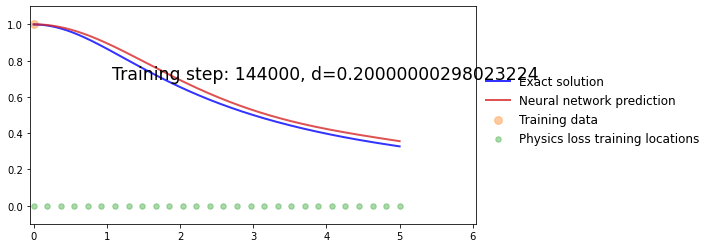

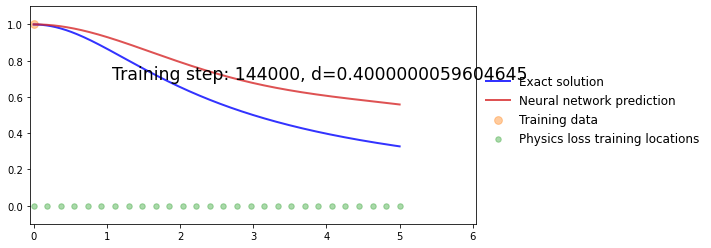

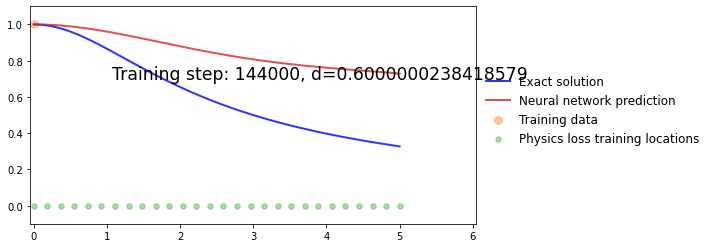

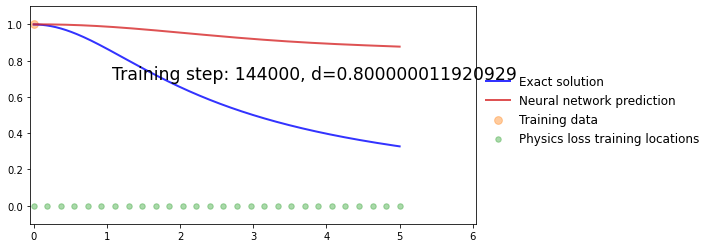

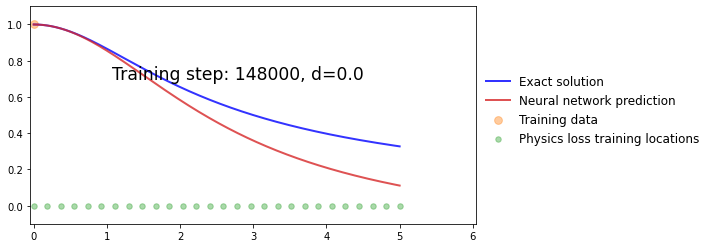

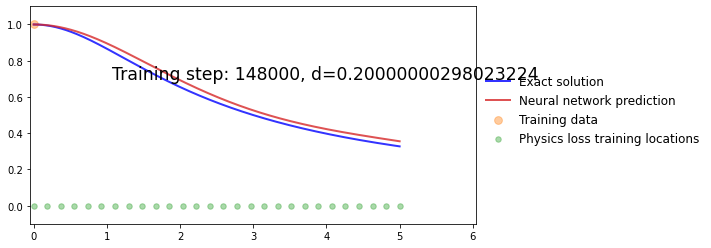

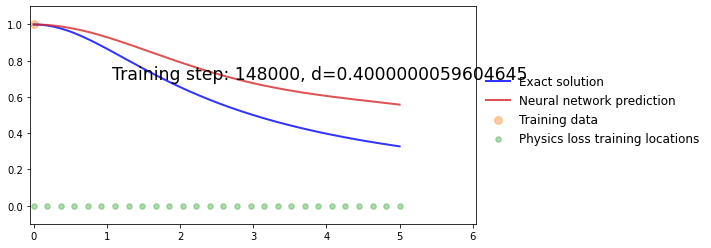

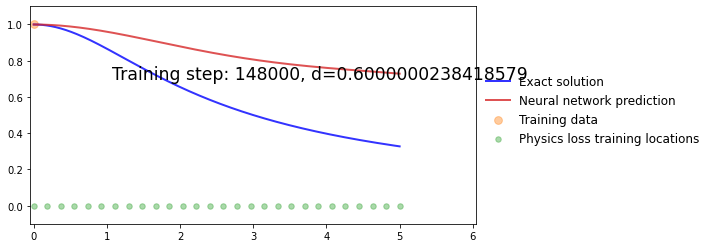

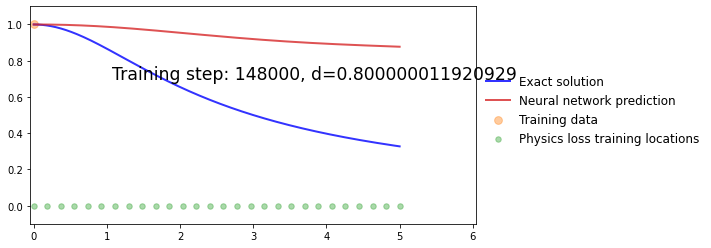

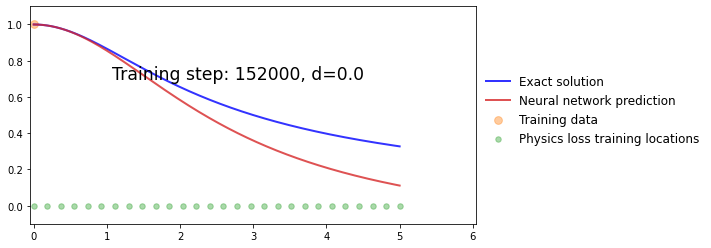

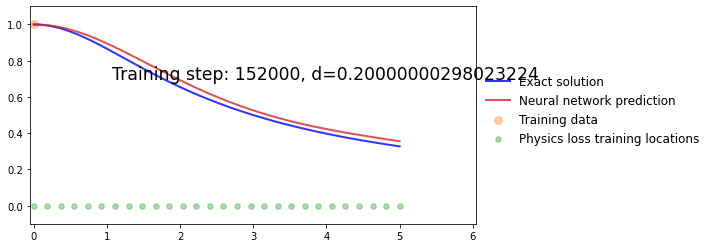

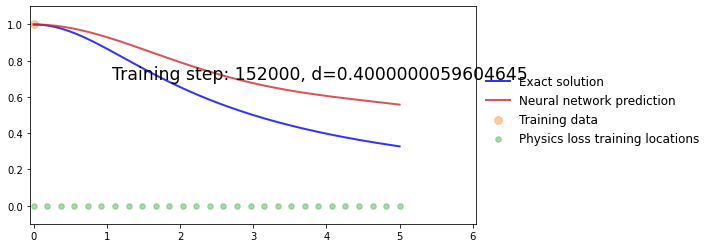

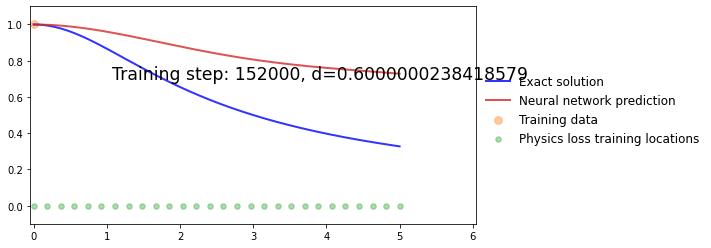

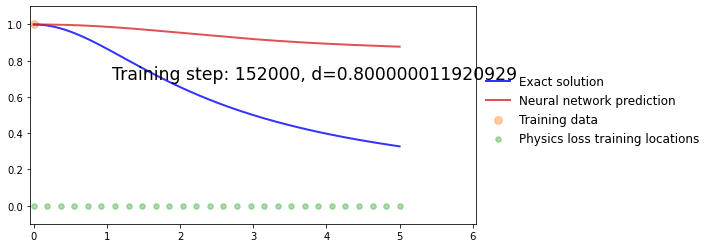

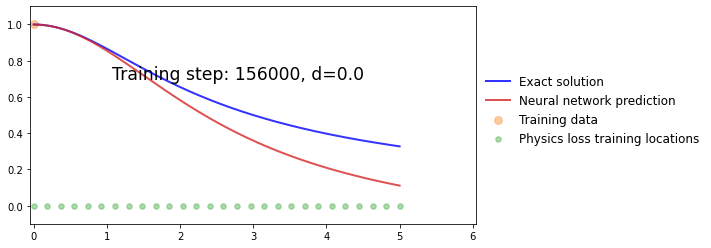

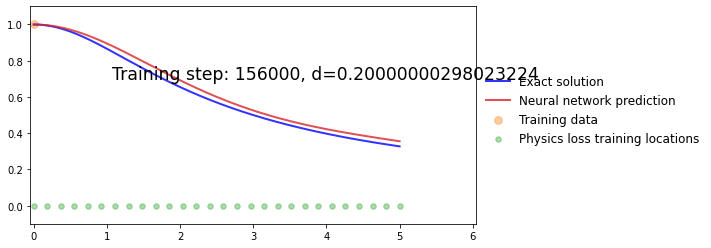

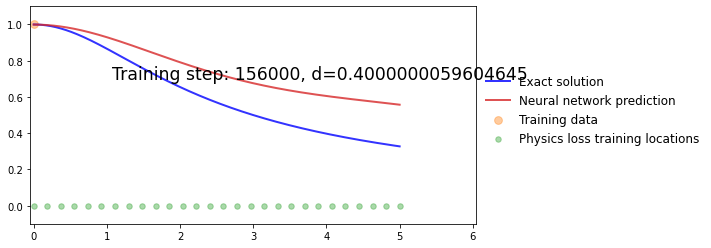

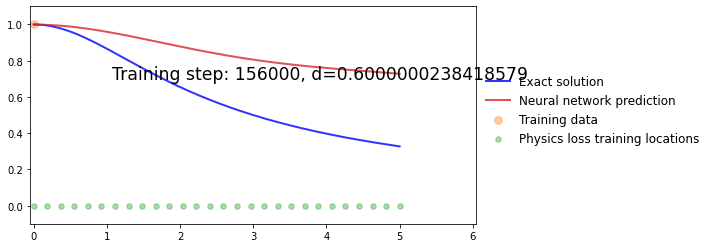

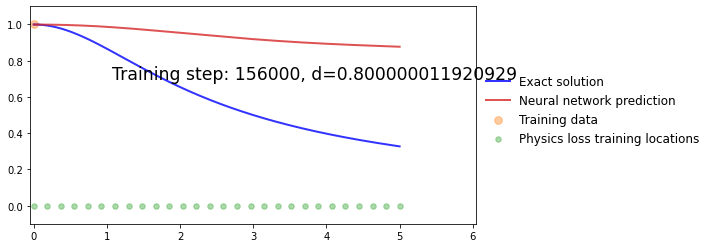

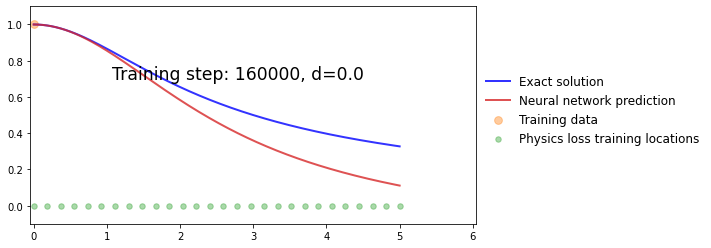

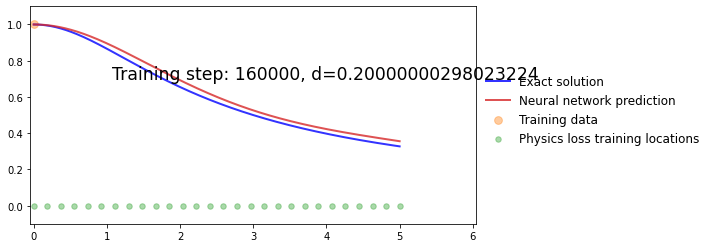

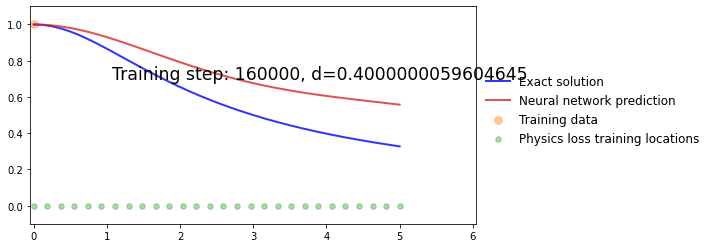

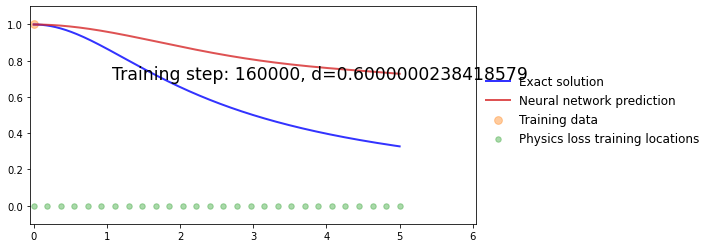

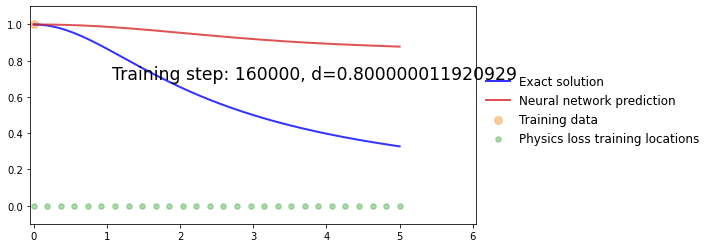

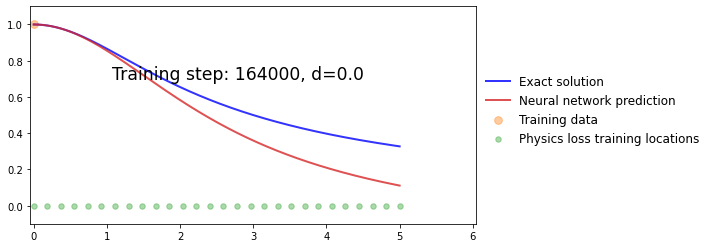

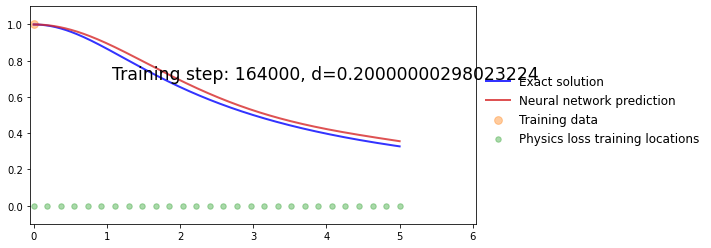

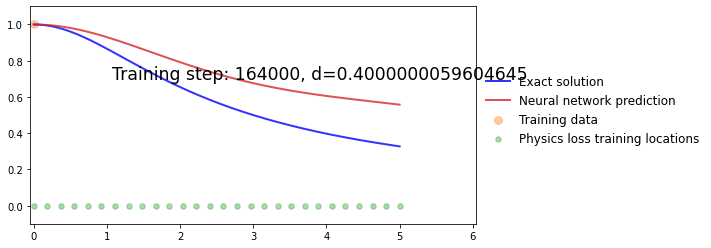

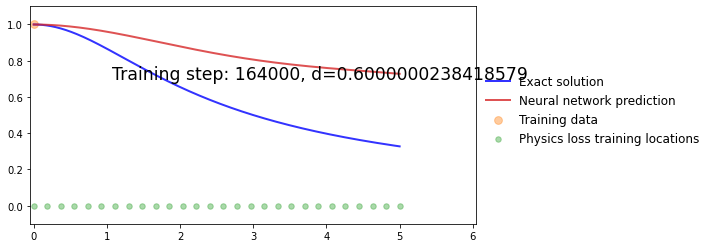

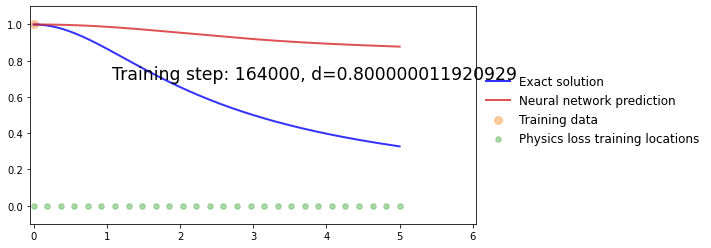

In [12]:
# Collocation dataset for x and for the C parameter .....
x_physics = torch.linspace(0,5,28)        
d_physics = torch.linspace(0.,0.8,5)

X_physics, D_physics = torch.meshgrid(x_physics, d_physics)
xin_physics = (torch.stack((X_physics.flatten(), D_physics.flatten())).T).requires_grad_(True)

indic = xin_physics[:, 1].view(-1, 1)
xpp = xin_physics[:, 0].view(-1, 1)
#indic is now the C parameter .................

torch.manual_seed(129)
model = FCN(2, 1, 20, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
files = []

loss_history = []
loss2_history = []
loss1_history = []
mse_history =[]


for i in range(164000):
    
    optimizer.zero_grad()
    
    # We compute the "data loss" .............................................
    yh = model(xin_data)
    loss1 = 1.*torch.mean((yh-yin_data)**2)# use mean squared error
      
    # We compute the "physics loss" .............................................
    yhp = model(xin_physics)
    dx = torch.autograd.grad(yhp, xin_physics, torch.ones_like(yhp),retain_graph=True, create_graph=True)[0]  
    dy_x = dx[:, [0]]
    
    dxx = torch.autograd.grad(dy_x, xin_physics, torch.ones_like(dy_x),retain_graph=True, create_graph=True)[0] 
    dy_xx = dxx[:, [0]]
   
    # We modify the data loss to take into account the first order derivative for the different C ....
    loss1 = loss1 + 0.01*torch.mean(dy_x[[0],:]**2) +  0.01*torch.mean(dy_x[[1],:]**2) + 0.01*torch.mean(dy_x[[2],:]**2)
    loss1 = loss1 + 0.01*torch.mean(dy_x[[3],:]**2) + 0.01*torch.mean(dy_x[[4],:]**2) + 0.*torch.mean(dy_x[[5],:]**2)
        
    # We compute the residual and physics loss .........................    
    physics = xpp*dy_xx + 2*dy_x + xpp*torch.abs((yhp**2 - indic))**1.5     
    loss2 = (8.e-2)*(torch.mean(physics**2))
    
    # We backpropagate total loss ................................................
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # We plot the result as training progresses ....................................
    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())
        loss1_history.append(loss1.detach())        
        
        yh = model(xin).detach()
        xp = xin_physics.detach()    
        
        for d_value in d:
            plot_result(xin, yin, xin_data, yin_data, yh, d_value, xp)
                
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            

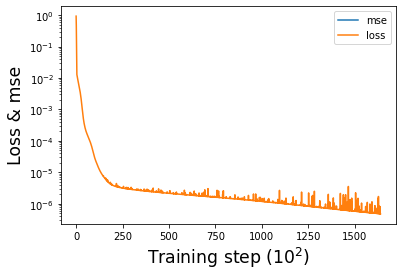

In [13]:
plt.plot(mse_history,label='mse')
plt.plot(loss_history,label='loss')
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss & mse',fontsize="xx-large")
plt.yscale('log')
plt.legend()

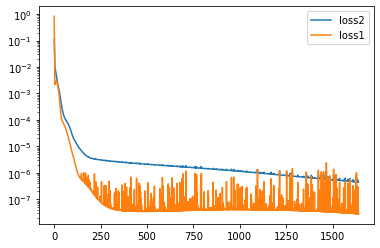

In [14]:
plt.plot(loss2_history, label="loss2")
plt.plot(loss1_history, label="loss1")
plt.yscale('log')
plt.legend()

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000])


Text(0.5, 1.0, 'White dwarf solutions - predicted versus exact')

<Figure size 432x288 with 0 Axes>

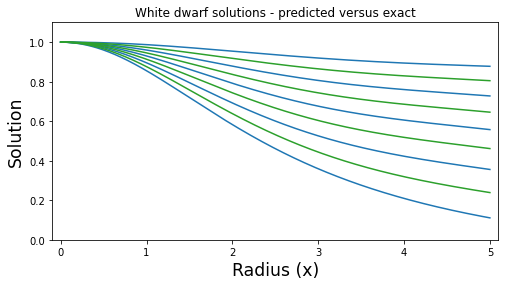

In [18]:
xx = torch.linspace(0, 5, 500)
dd = torch.linspace(0., 0.8, 17)
print(dd)

XX, DD = torch.meshgrid(xx, dd)
xinpr = torch.stack((XX.flatten(), DD.flatten())).T

yhppre = model(xinpr).detach()


fig5 = plt.figure(5)


muv=0.2
xinpr_slice = xinpr[:, 1] == muv

plt.figure(figsize=(8,4))
plt.xlim(-0.1, 5.1)
plt.ylim(0., 1.1)
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0], color="tab:blue", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0], color="tab:blue", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.4
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0], color="tab:blue", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.6
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0],color="tab:blue", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.8
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0],color="tab:blue", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.5
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0],color="tab:green", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.1
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0], color="tab:green", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.3
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0], color="tab:green", label="prediction")
#print(yhppre[xinpr_slice, 0] )

yhppre = model(xinpr).detach()
muv=0.7
xinpr_slice = xinpr[:, 1] == muv
plt.plot(xinpr[xinpr_slice, 0], yhppre[xinpr_slice, 0], color="tab:green", label="prediction")
#print(yhppre[xinpr_slice, 0] )

#plt.plot(xn, yh2, color="red")

plt.xlabel("Radius (x)",fontsize="xx-large")
plt.ylabel("Solution",fontsize="xx-large")
plt.title("White dwarf solutions - predicted versus exact")




tensor(1.6502e-07)


tensor(nan)
